### Initial run

Initial end to end test, a sort of a "teaser" to highlight the motivation for `concurrent_dataloader`. 

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments/initial_run")

In [3]:
s3_folder_filter="1011_4/*benchmark_e2e*"
scratch_folder_filter="1111_5/*benchmark_e2e*"

Load the data

In [4]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426/426 [00:01<00:00, 227.13it/s]


Create "colors" and "lanes". Colors are used to distinguish different function types, e.g. function that loads a batch, calls the `next_data`, `run_traning_batch` from Lightning and `training_batch_to_device` also from lightning.
Lanes, every single call of the aforementioned funcitons in their own respective lane, so we get a nice overview of when the function is called, and how long it tookl

In [5]:
named_colors = ["green", "orange", "lawngreen", "black", "gray", "teal"]
unique_functions = np.unique(df_dataloader_scratch["item_x"])
print(f"Unique functions: {unique_functions}")

# ensure that special functions (same for both Lightning and Torch approach) are always plotted in the same color
colors = {}
special_functions = ["batch", "training_batch_to_device", "run_training_batch"]
unique_functions = np.setdiff1d(unique_functions, special_functions)

for i, color in zip(special_functions, ["red", "magenta", "blue"]):
    colors[str(i)] = color
for i, color in zip(unique_functions, named_colors):
    colors[str(i)] = color    

    lanes={}
for i, lane in zip(unique_functions, range(len(unique_functions))):
    lanes[str(i)] = lane
    
    
unique_runs_s3 = np.unique(df_dataloader_s3["run"])
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


Extract the GPU Utilization data

In [6]:
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [00:01<00:00, 352.66it/s]


In [7]:
df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 426/426 [00:00<00:00, 4681.56it/s]


Get unique runs to loop through, and plot the results

In [8]:
unique_runs_s3 = np.unique(df_dataloader_s3["run"])

In [9]:
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

In [10]:
print(unique_runs_s3, unique_runs_scratch)

['20211110f232825_benchmark_e2e_torch_s3_256_4_16_1_threaded_sync'
 '20211110f234524_benchmark_e2e_lightning_s3_256_4_16_1_threaded_sync'
 '20211111f000909_benchmark_e2e_torch_s3_256_4_16_1_asyncio_sync'
 '20211111f002644_benchmark_e2e_lightning_s3_256_4_16_1_asyncio_sync'
 '20211111f005129_benchmark_e2e_torch_s3_256_4_16_1_vanilla_sync'
 '20211111f031032_benchmark_e2e_lightning_s3_256_4_16_1_vanilla_sync'] ['20211111f205911_benchmark_e2e_torch_scratch_256_4_16_1_threaded_sync'
 '20211111f210705_benchmark_e2e_lightning_scratch_256_4_16_1_threaded_sync'
 '20211111f212315_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync'
 '20211111f213057_benchmark_e2e_lightning_scratch_256_4_16_1_asyncio_sync'
 '20211111f214714_benchmark_e2e_torch_scratch_256_4_16_1_vanilla_sync'
 '20211111f215633_benchmark_e2e_lightning_scratch_256_4_16_1_vanilla_sync']


### Plot function timelines for remote storage (AWS S3)

64.74193548387096 39.53448275862069


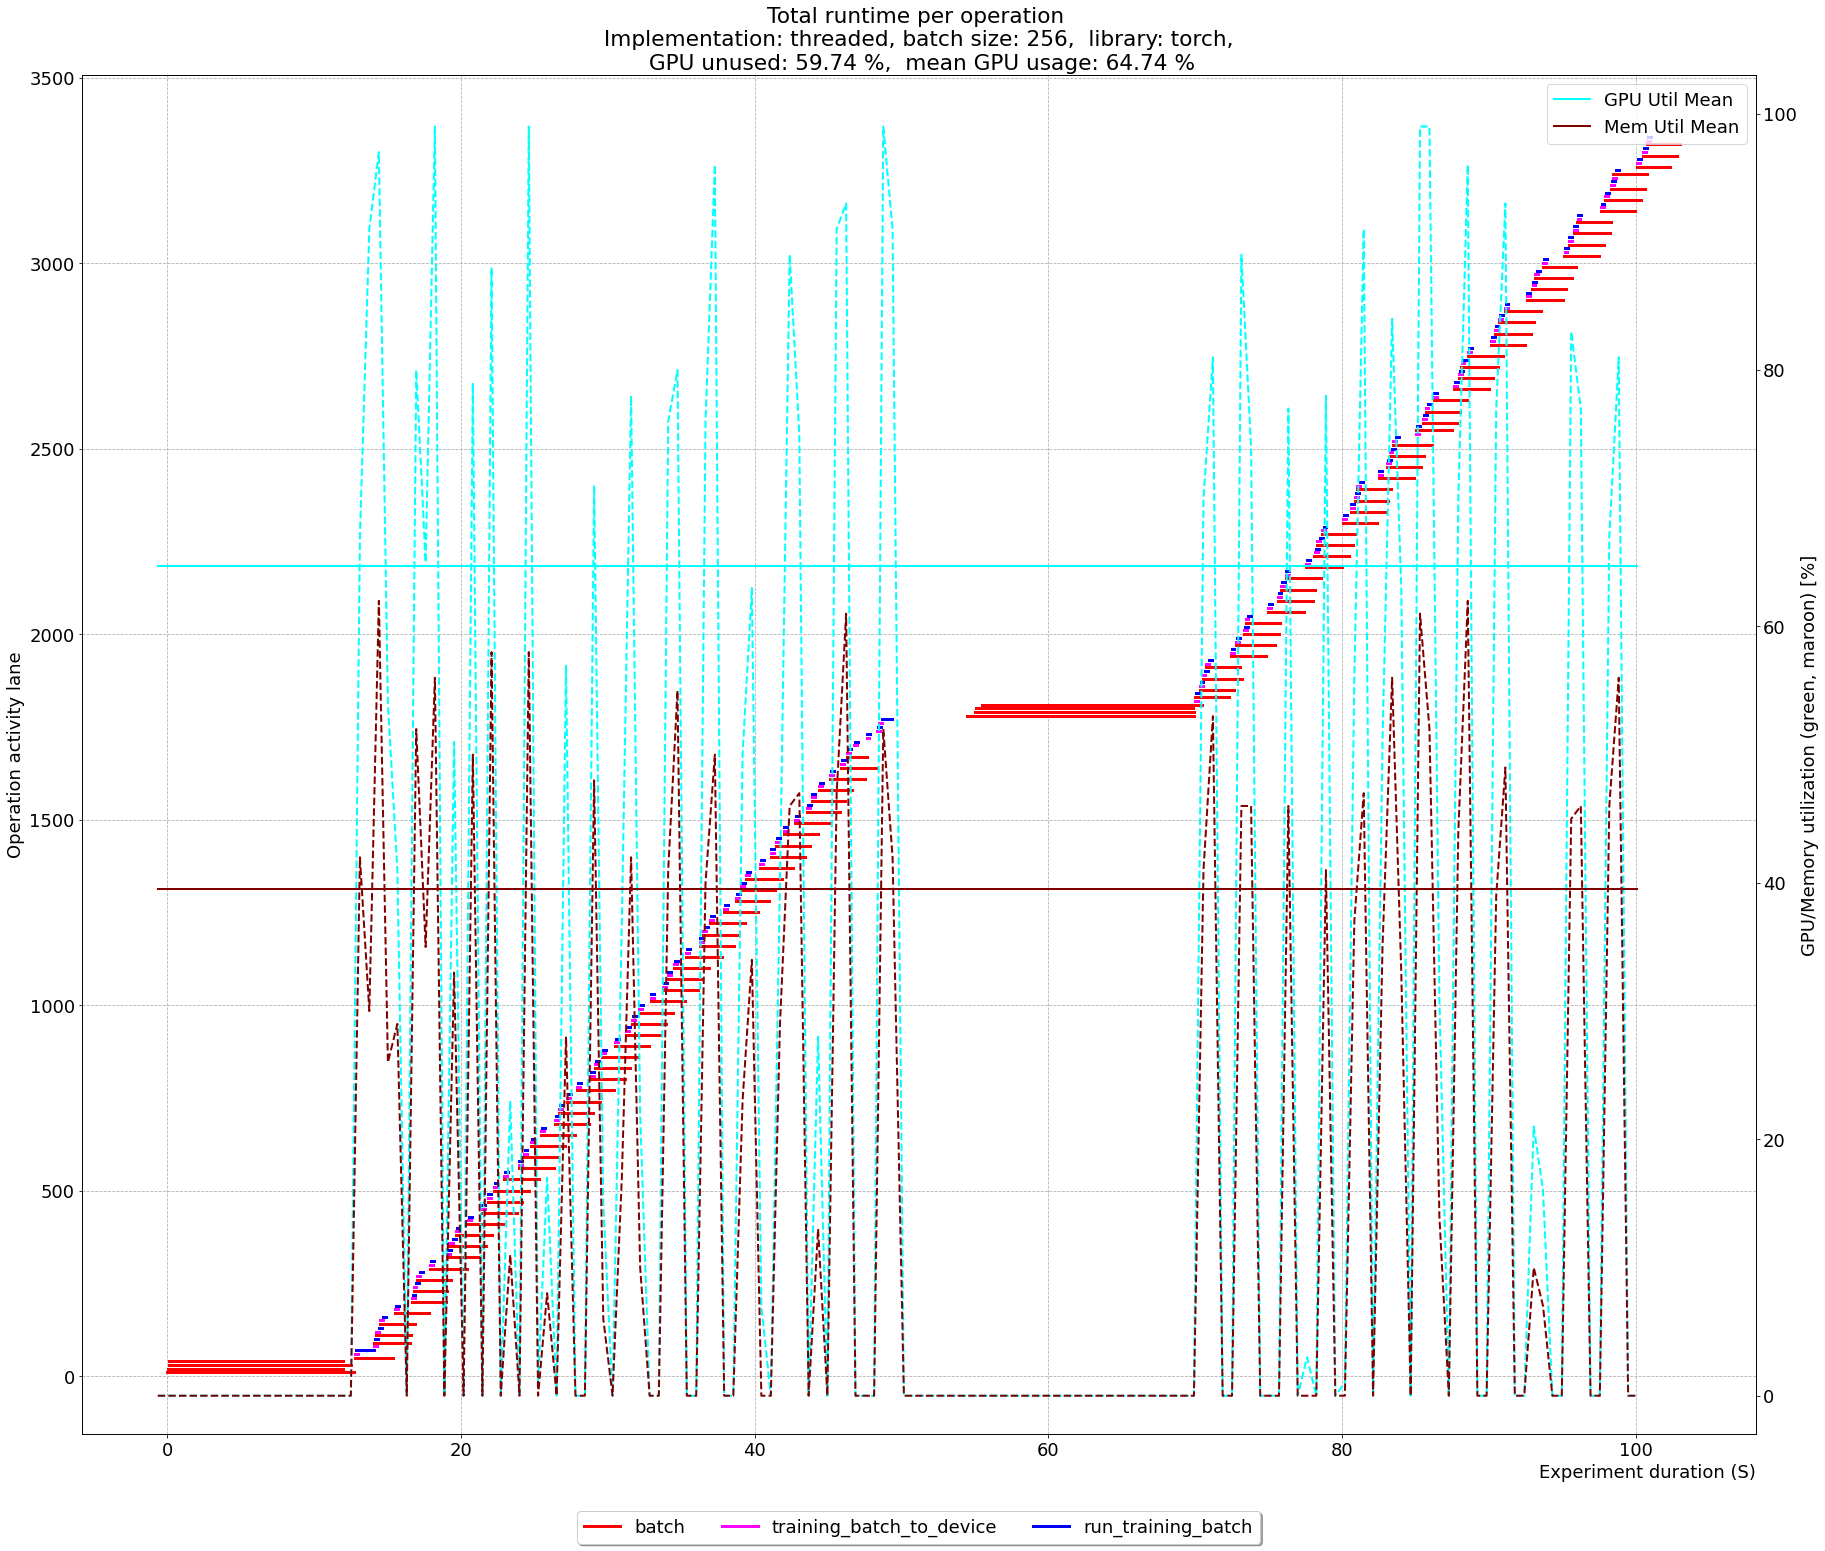

57.883495145631066 23.06896551724138


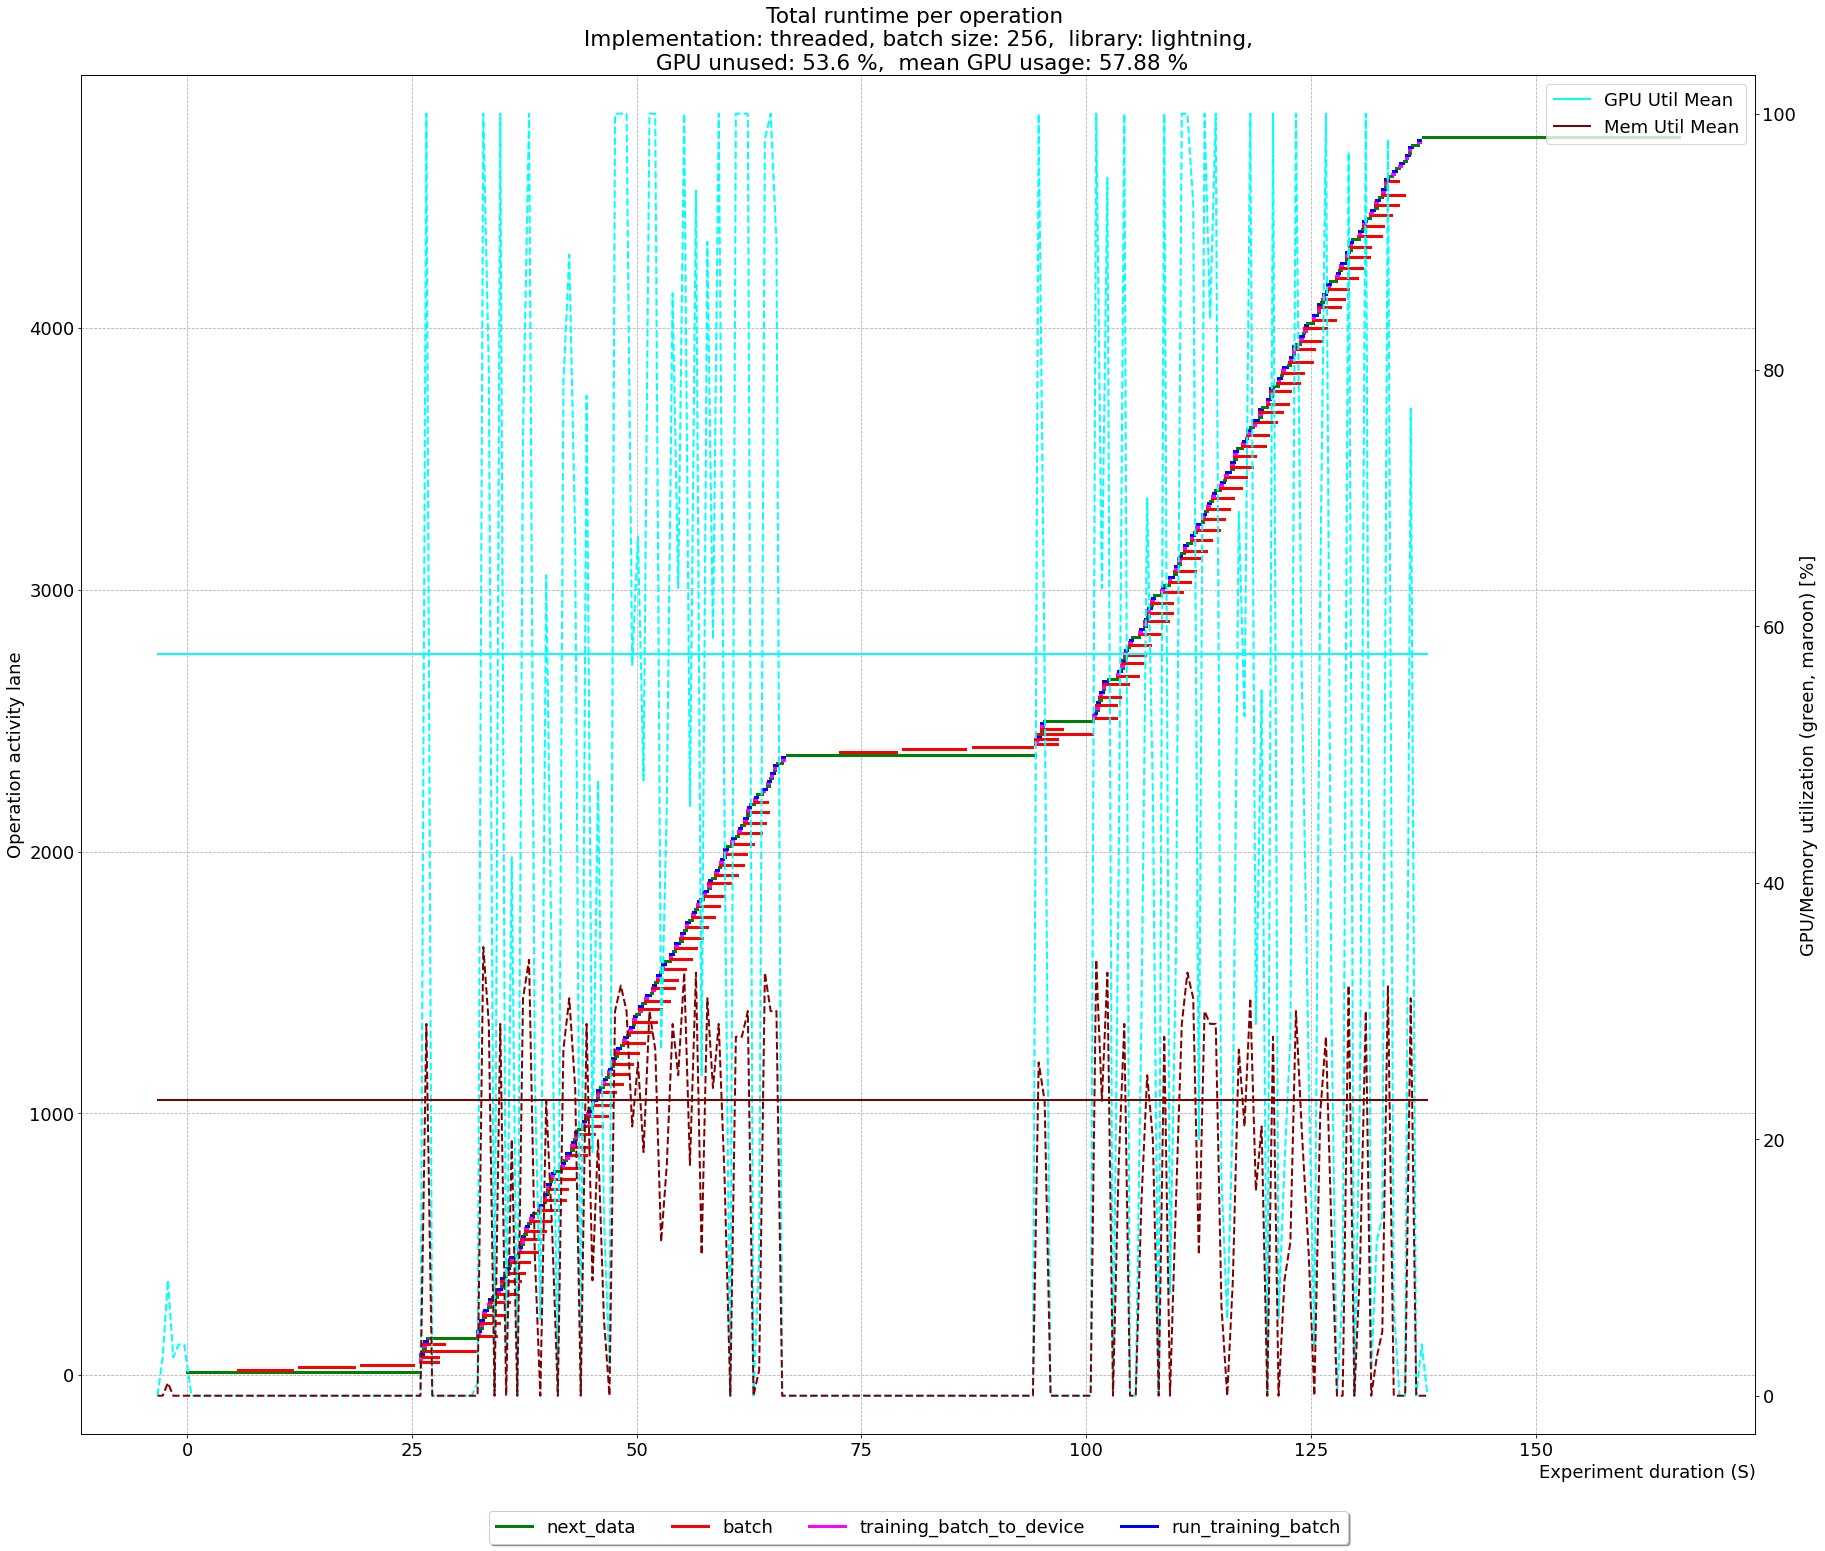

57.885245901639344 35.45283018867924


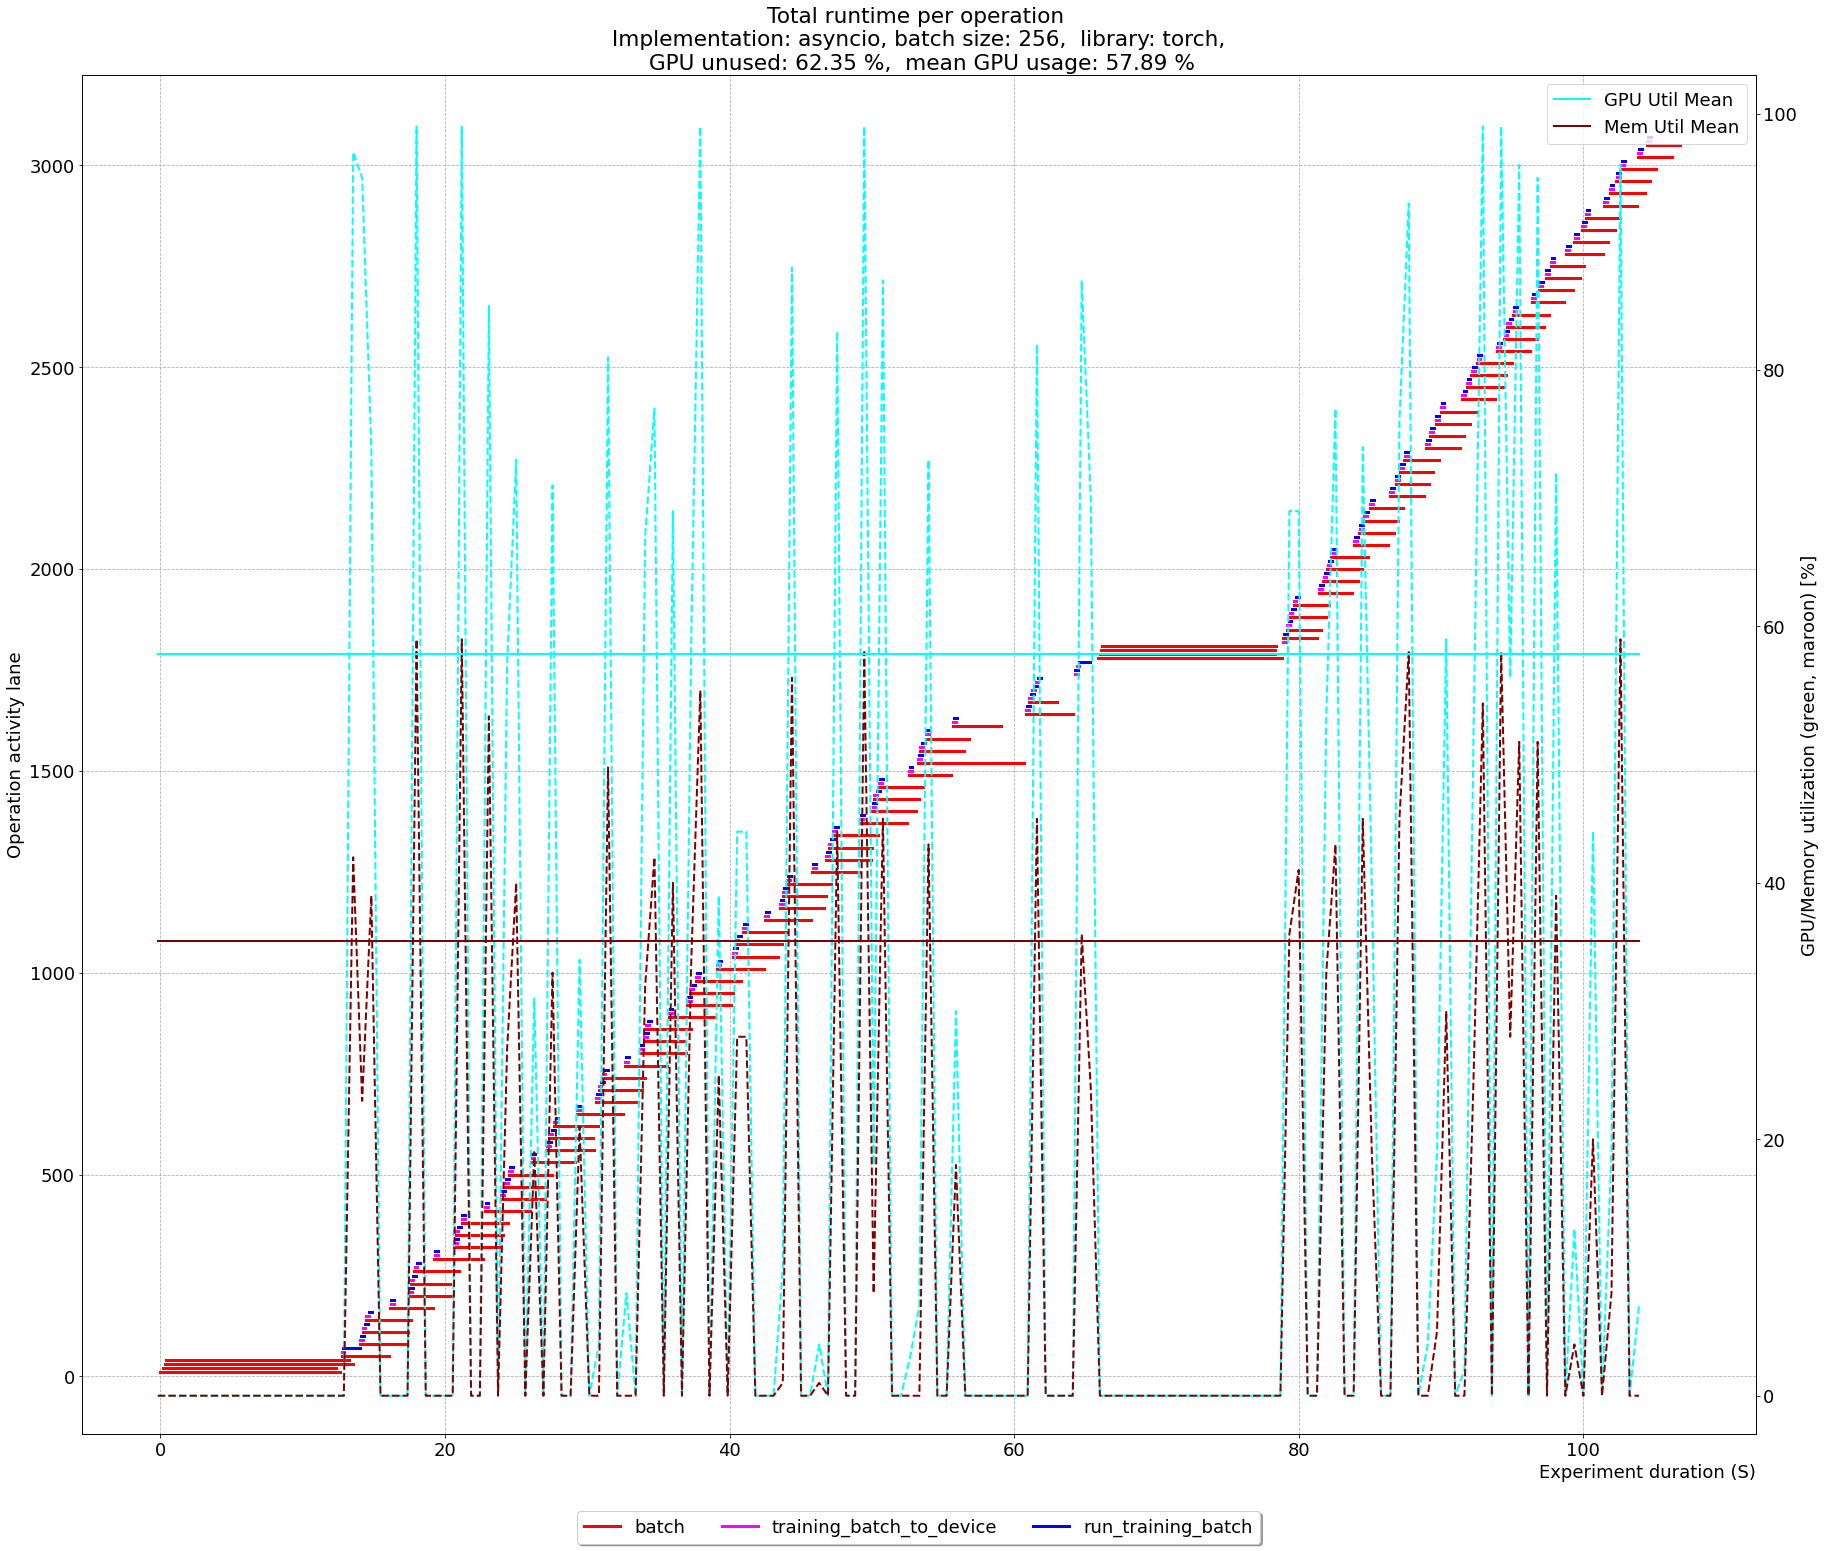

60.8125 23.794117647058822


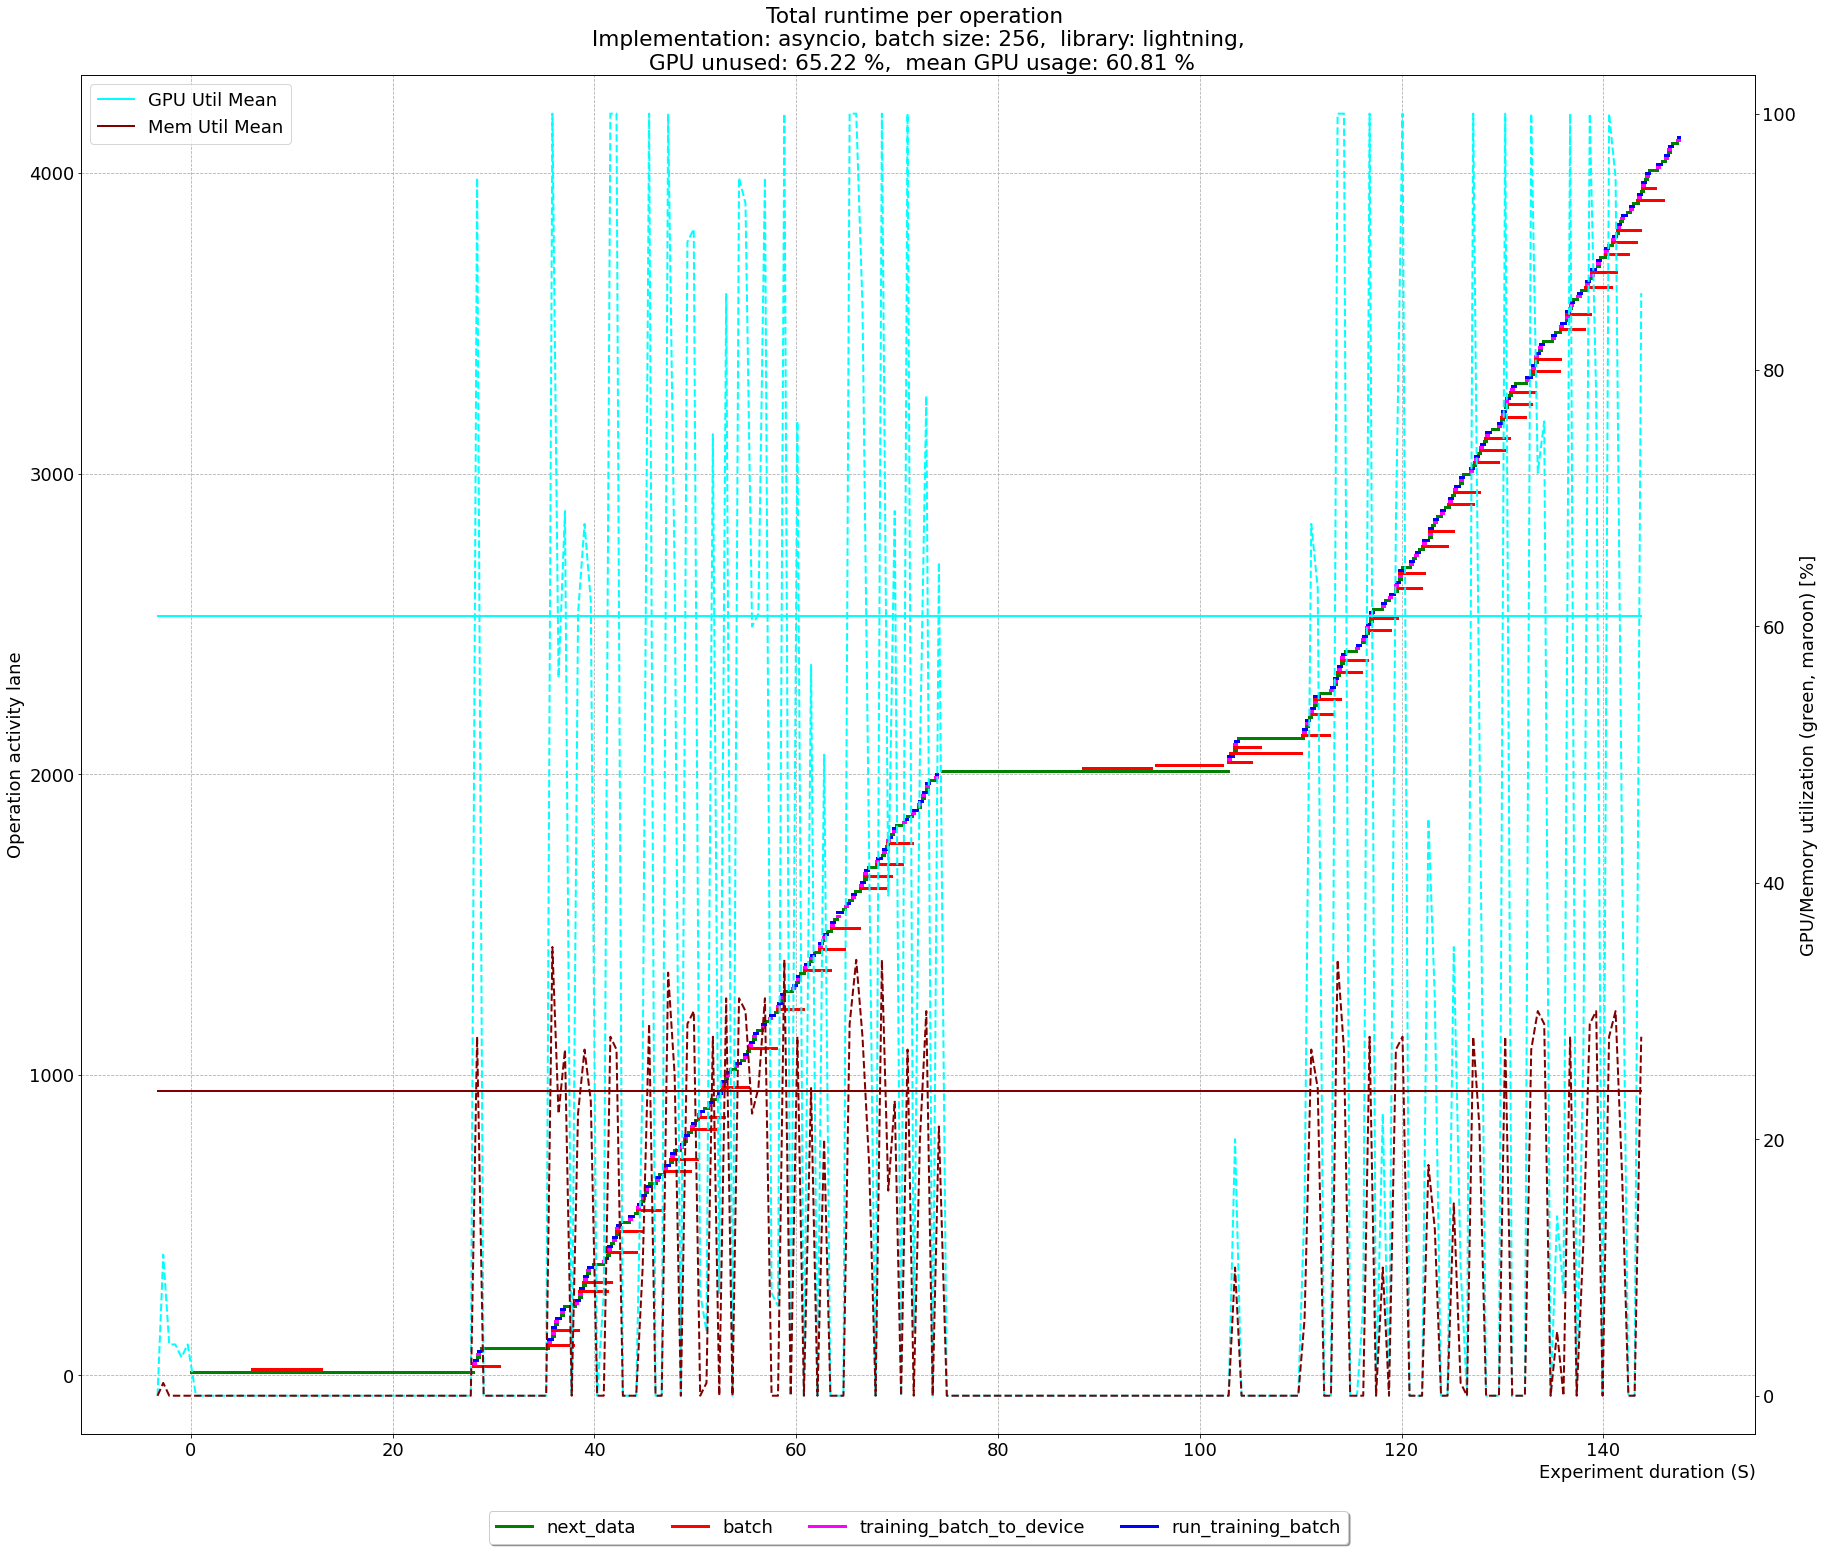

59.9873417721519 35.178082191780824


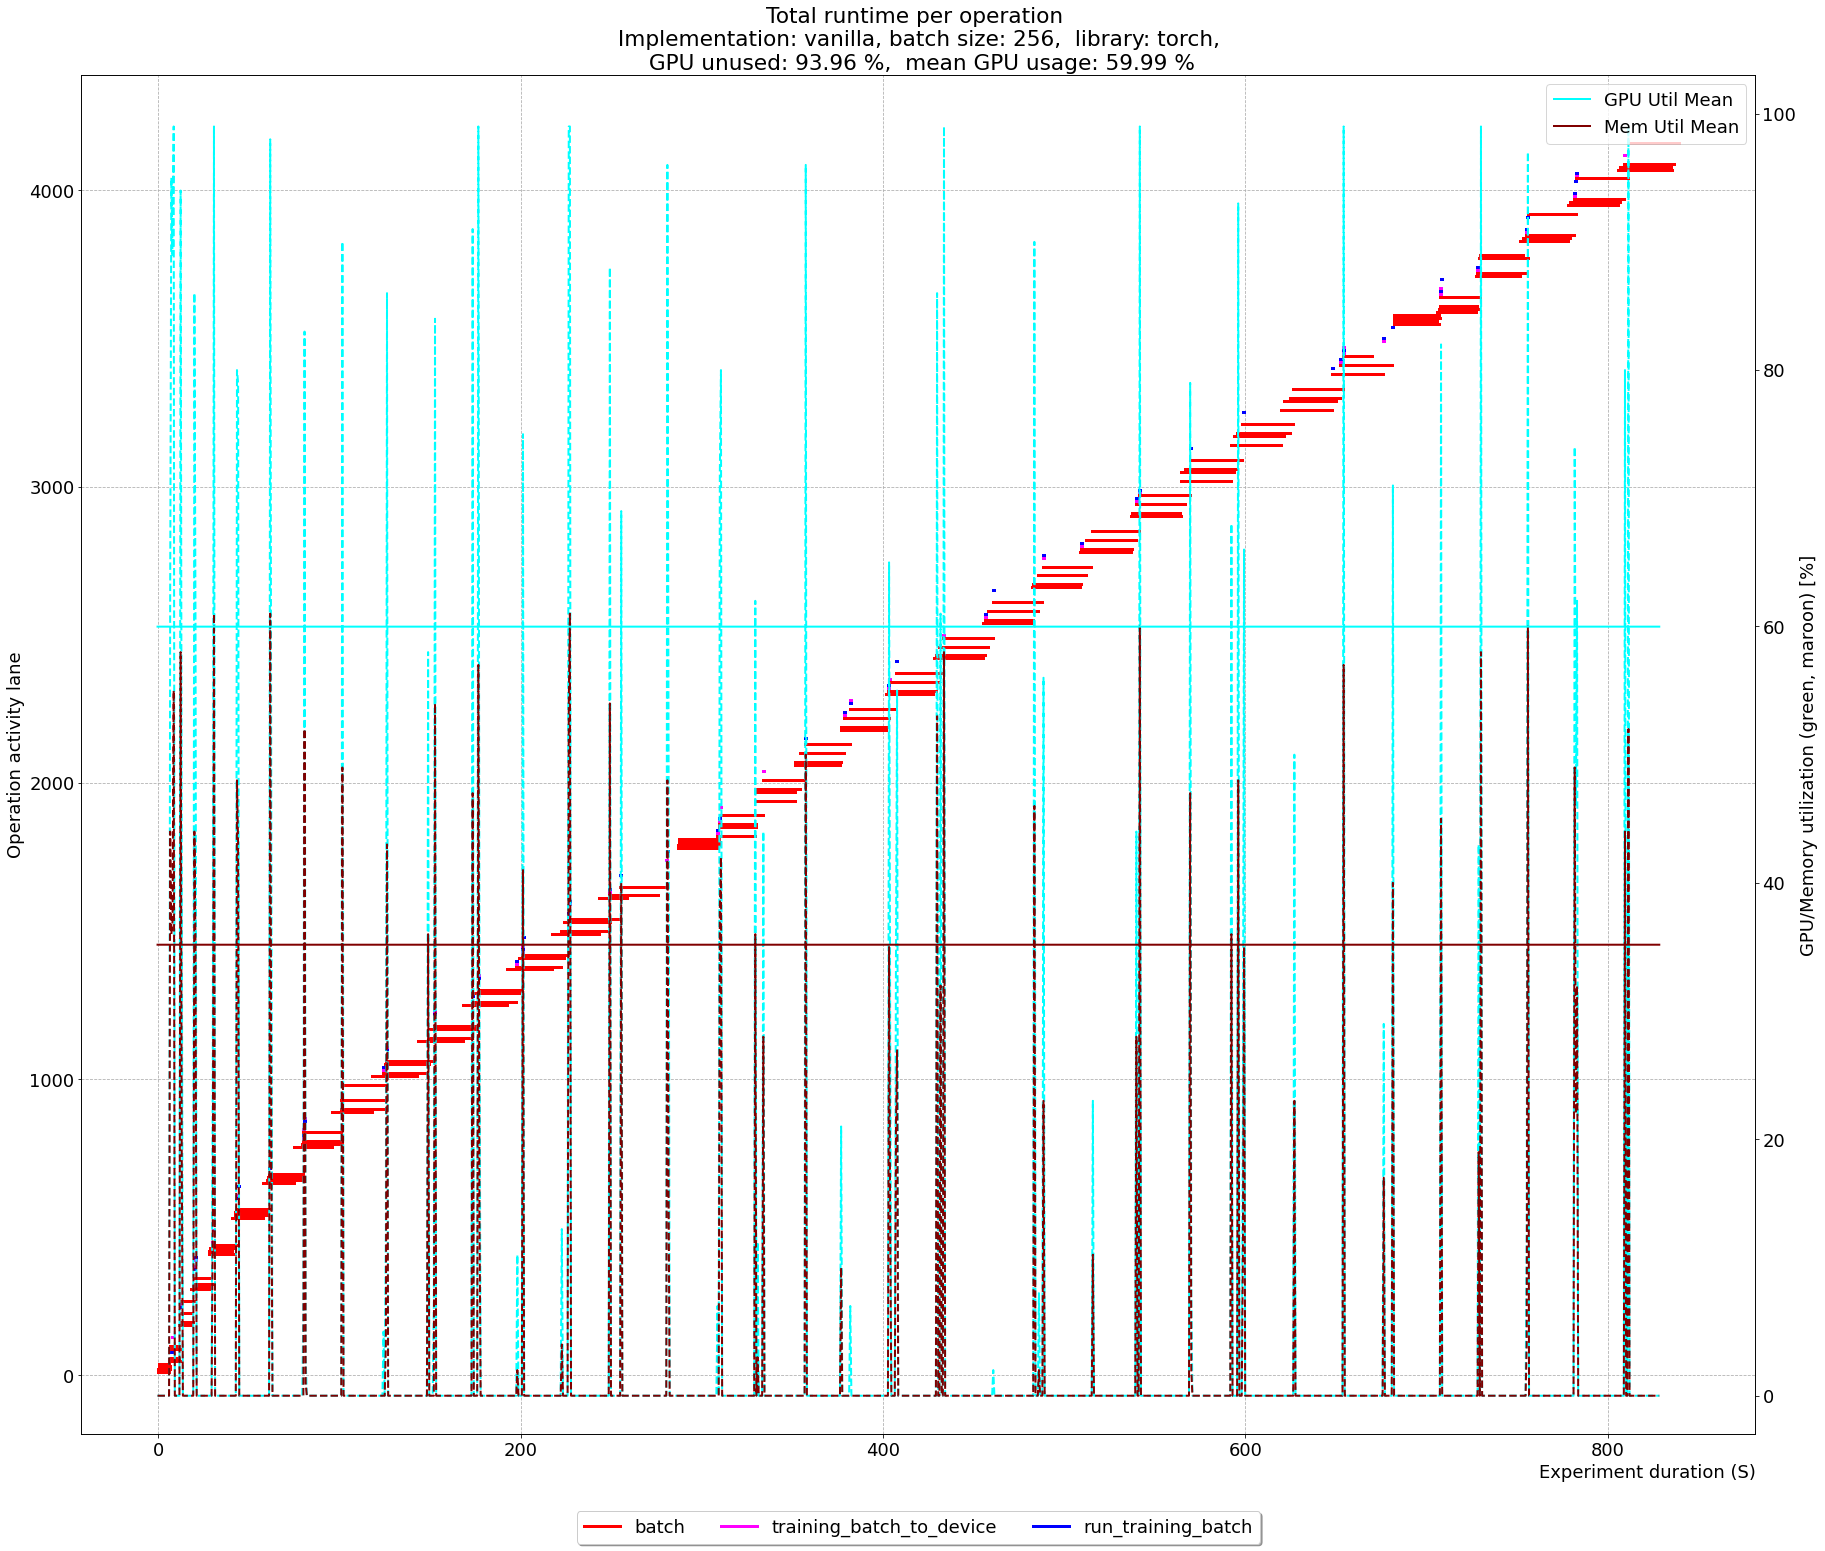

64.05714285714286 23.45263157894737


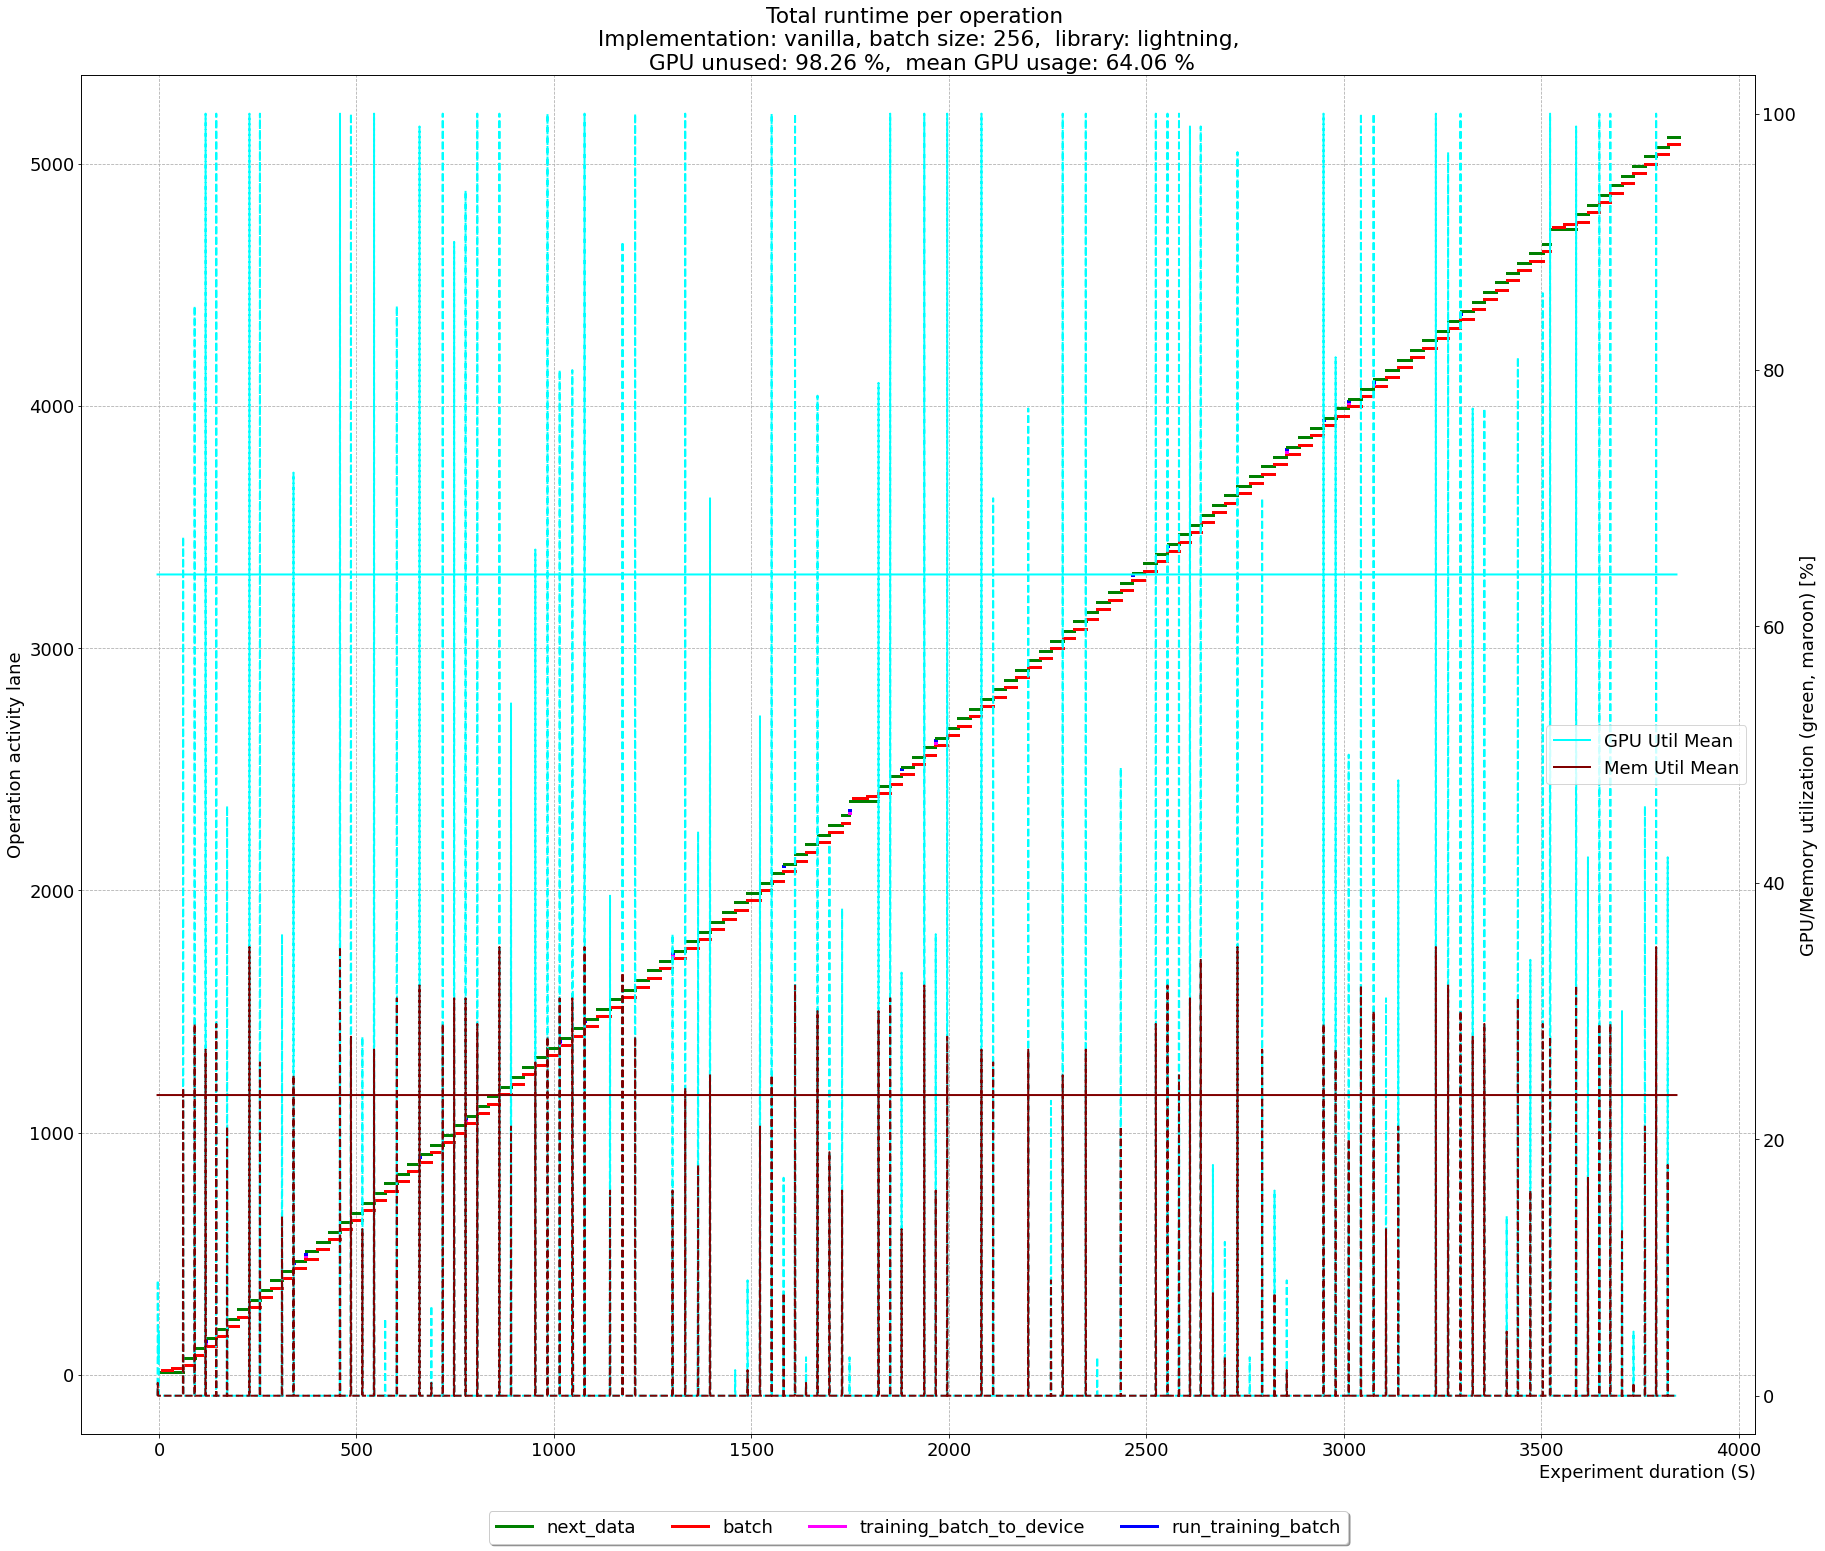

In [56]:
returns_s3 = []
for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False) 
    result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, True, 2)
    result["run"]=run
    returns_s3.append(result)


### Plot function timelines for local storage

78.12 46.270833333333336


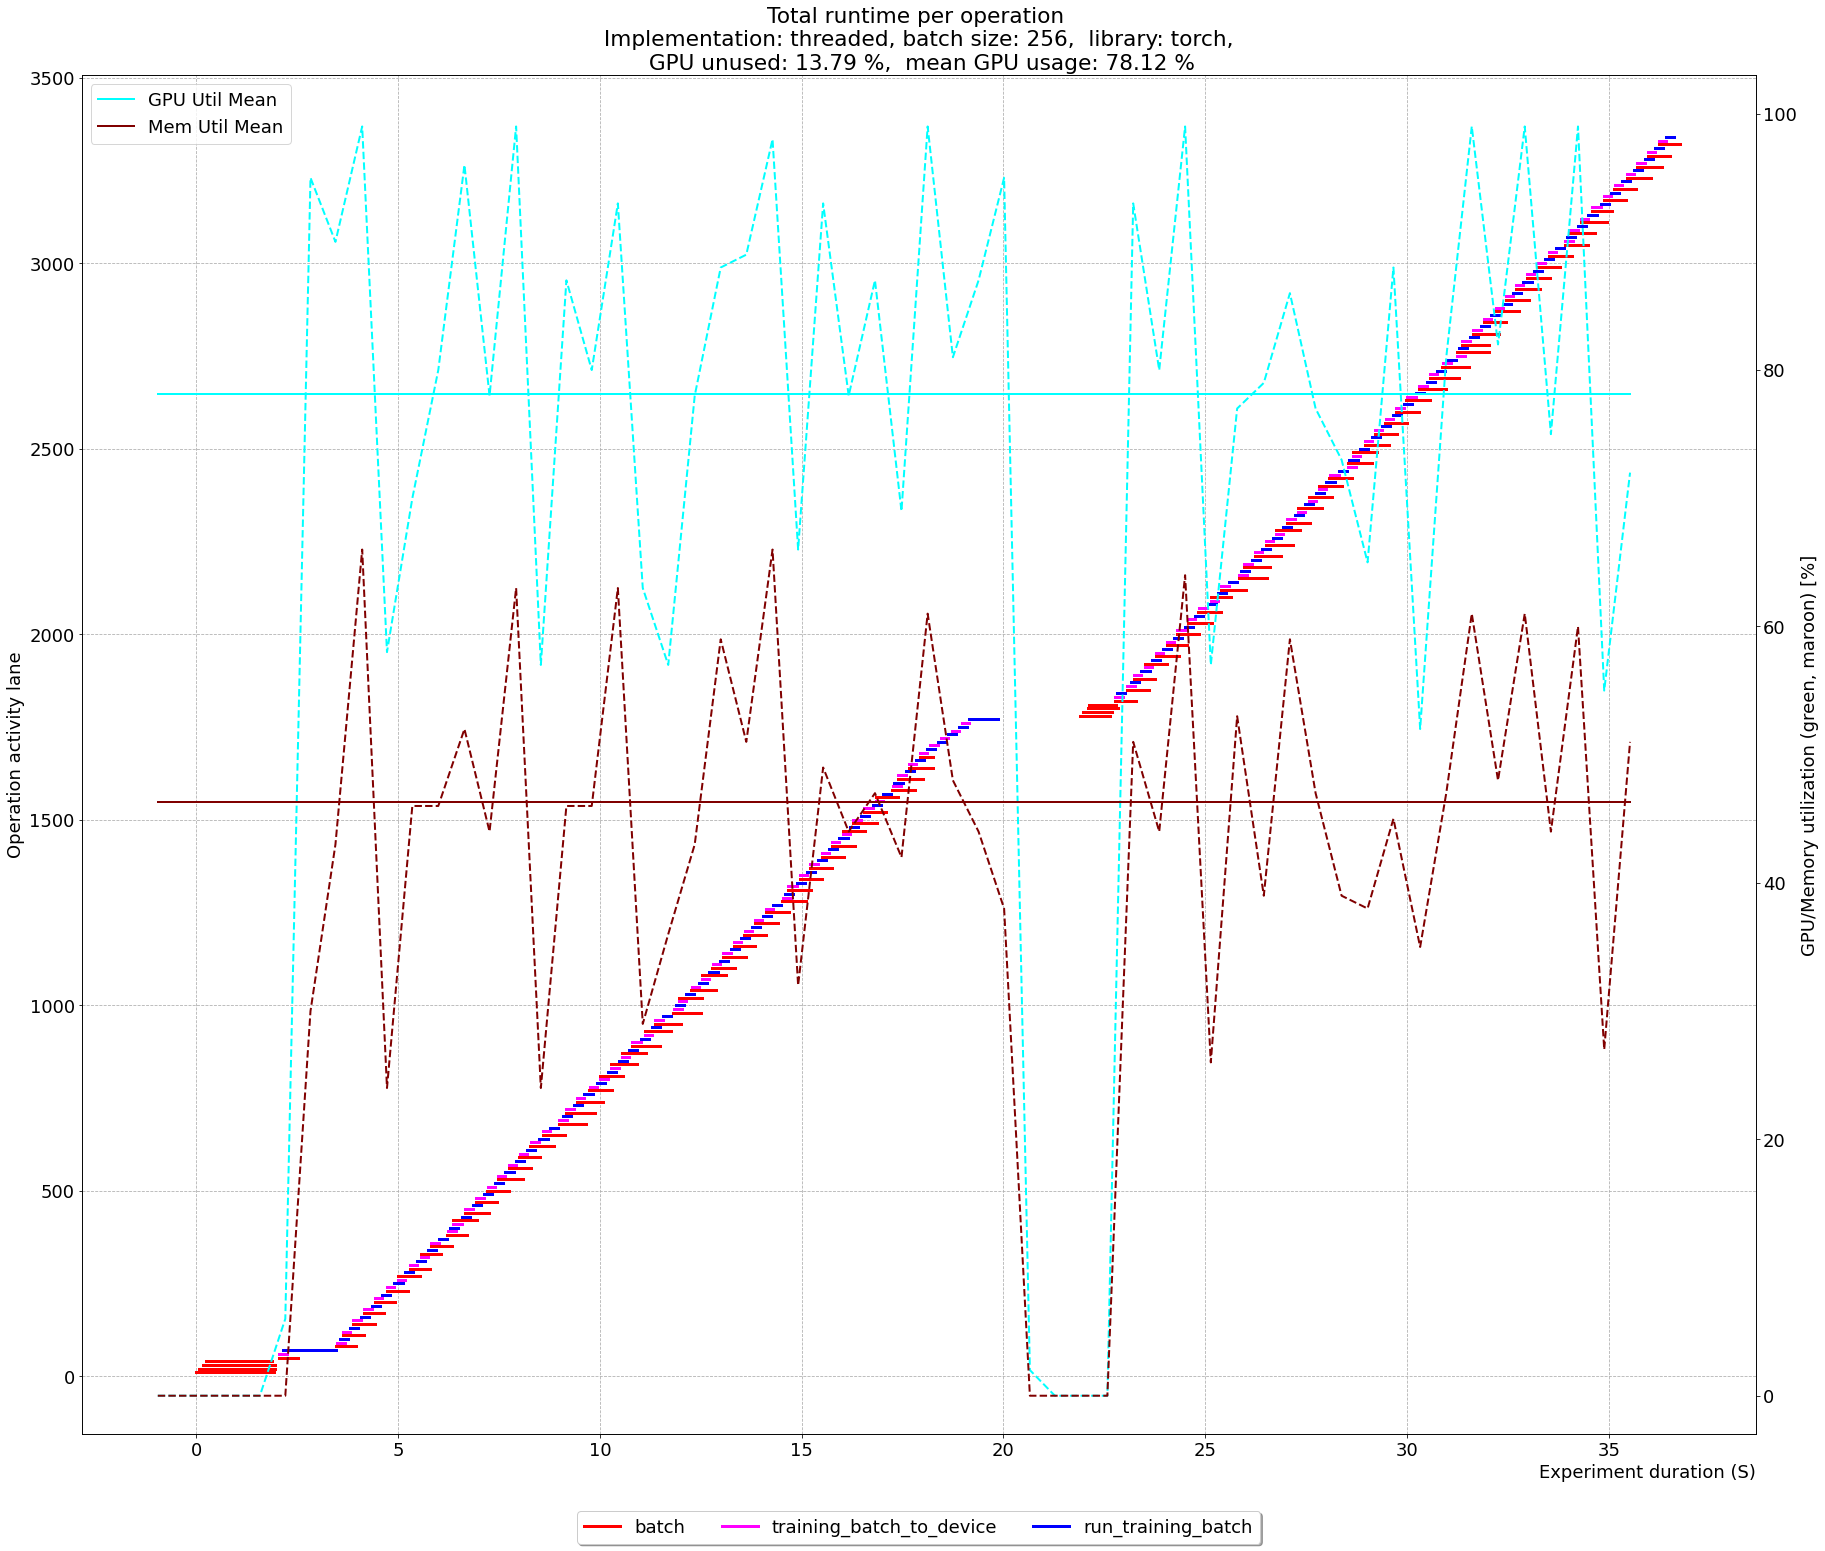

67.59740259740259 25.58823529411765


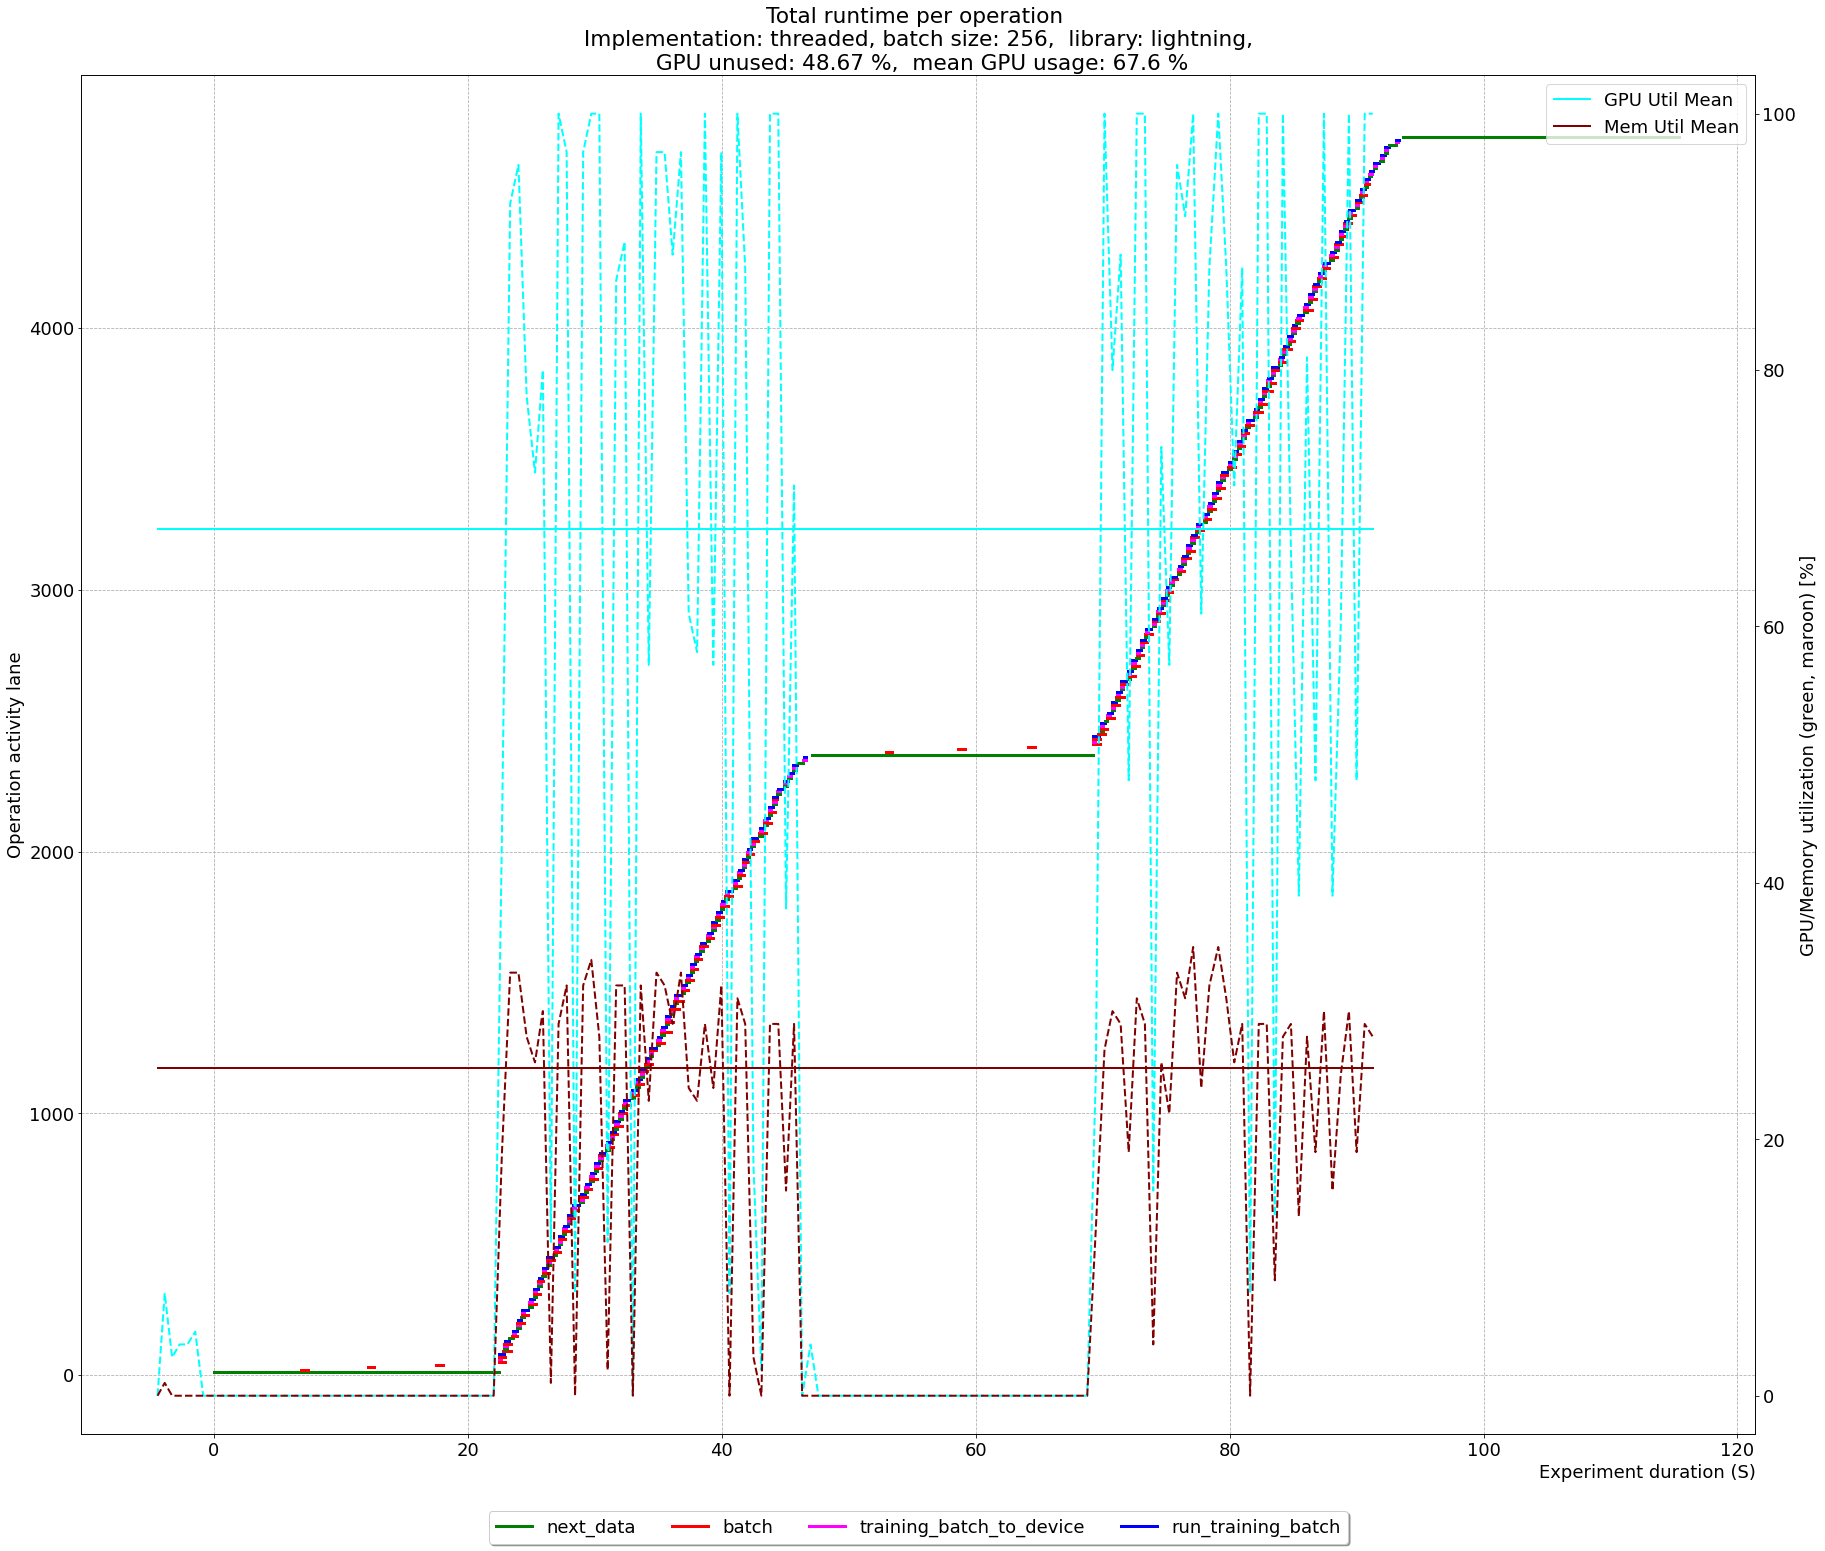

76.5 42.68


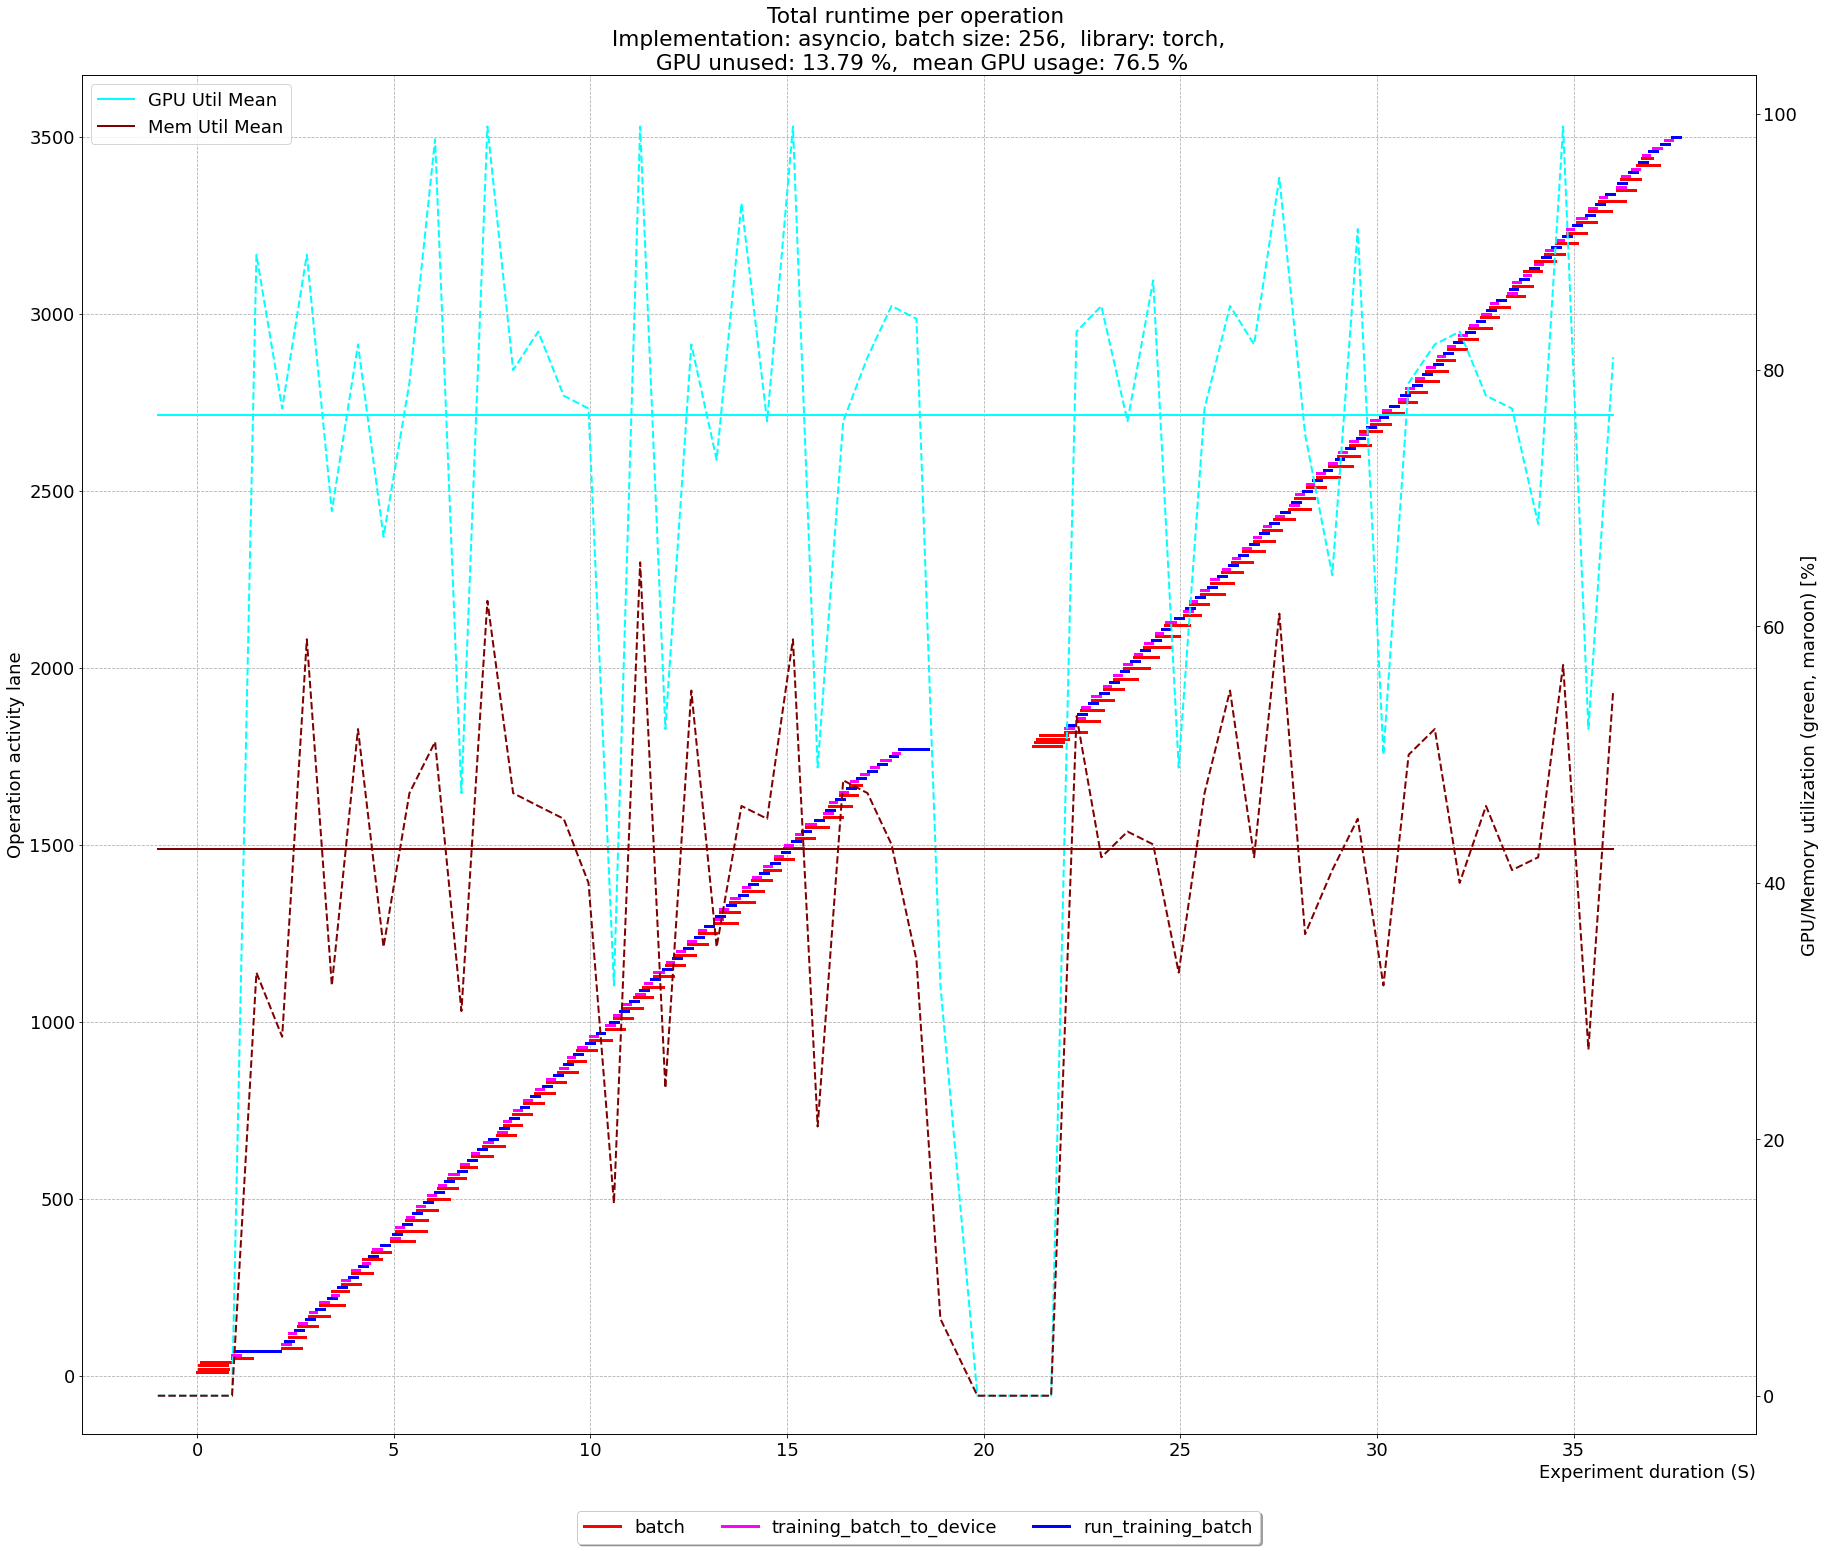

65.1038961038961 24.405797101449274


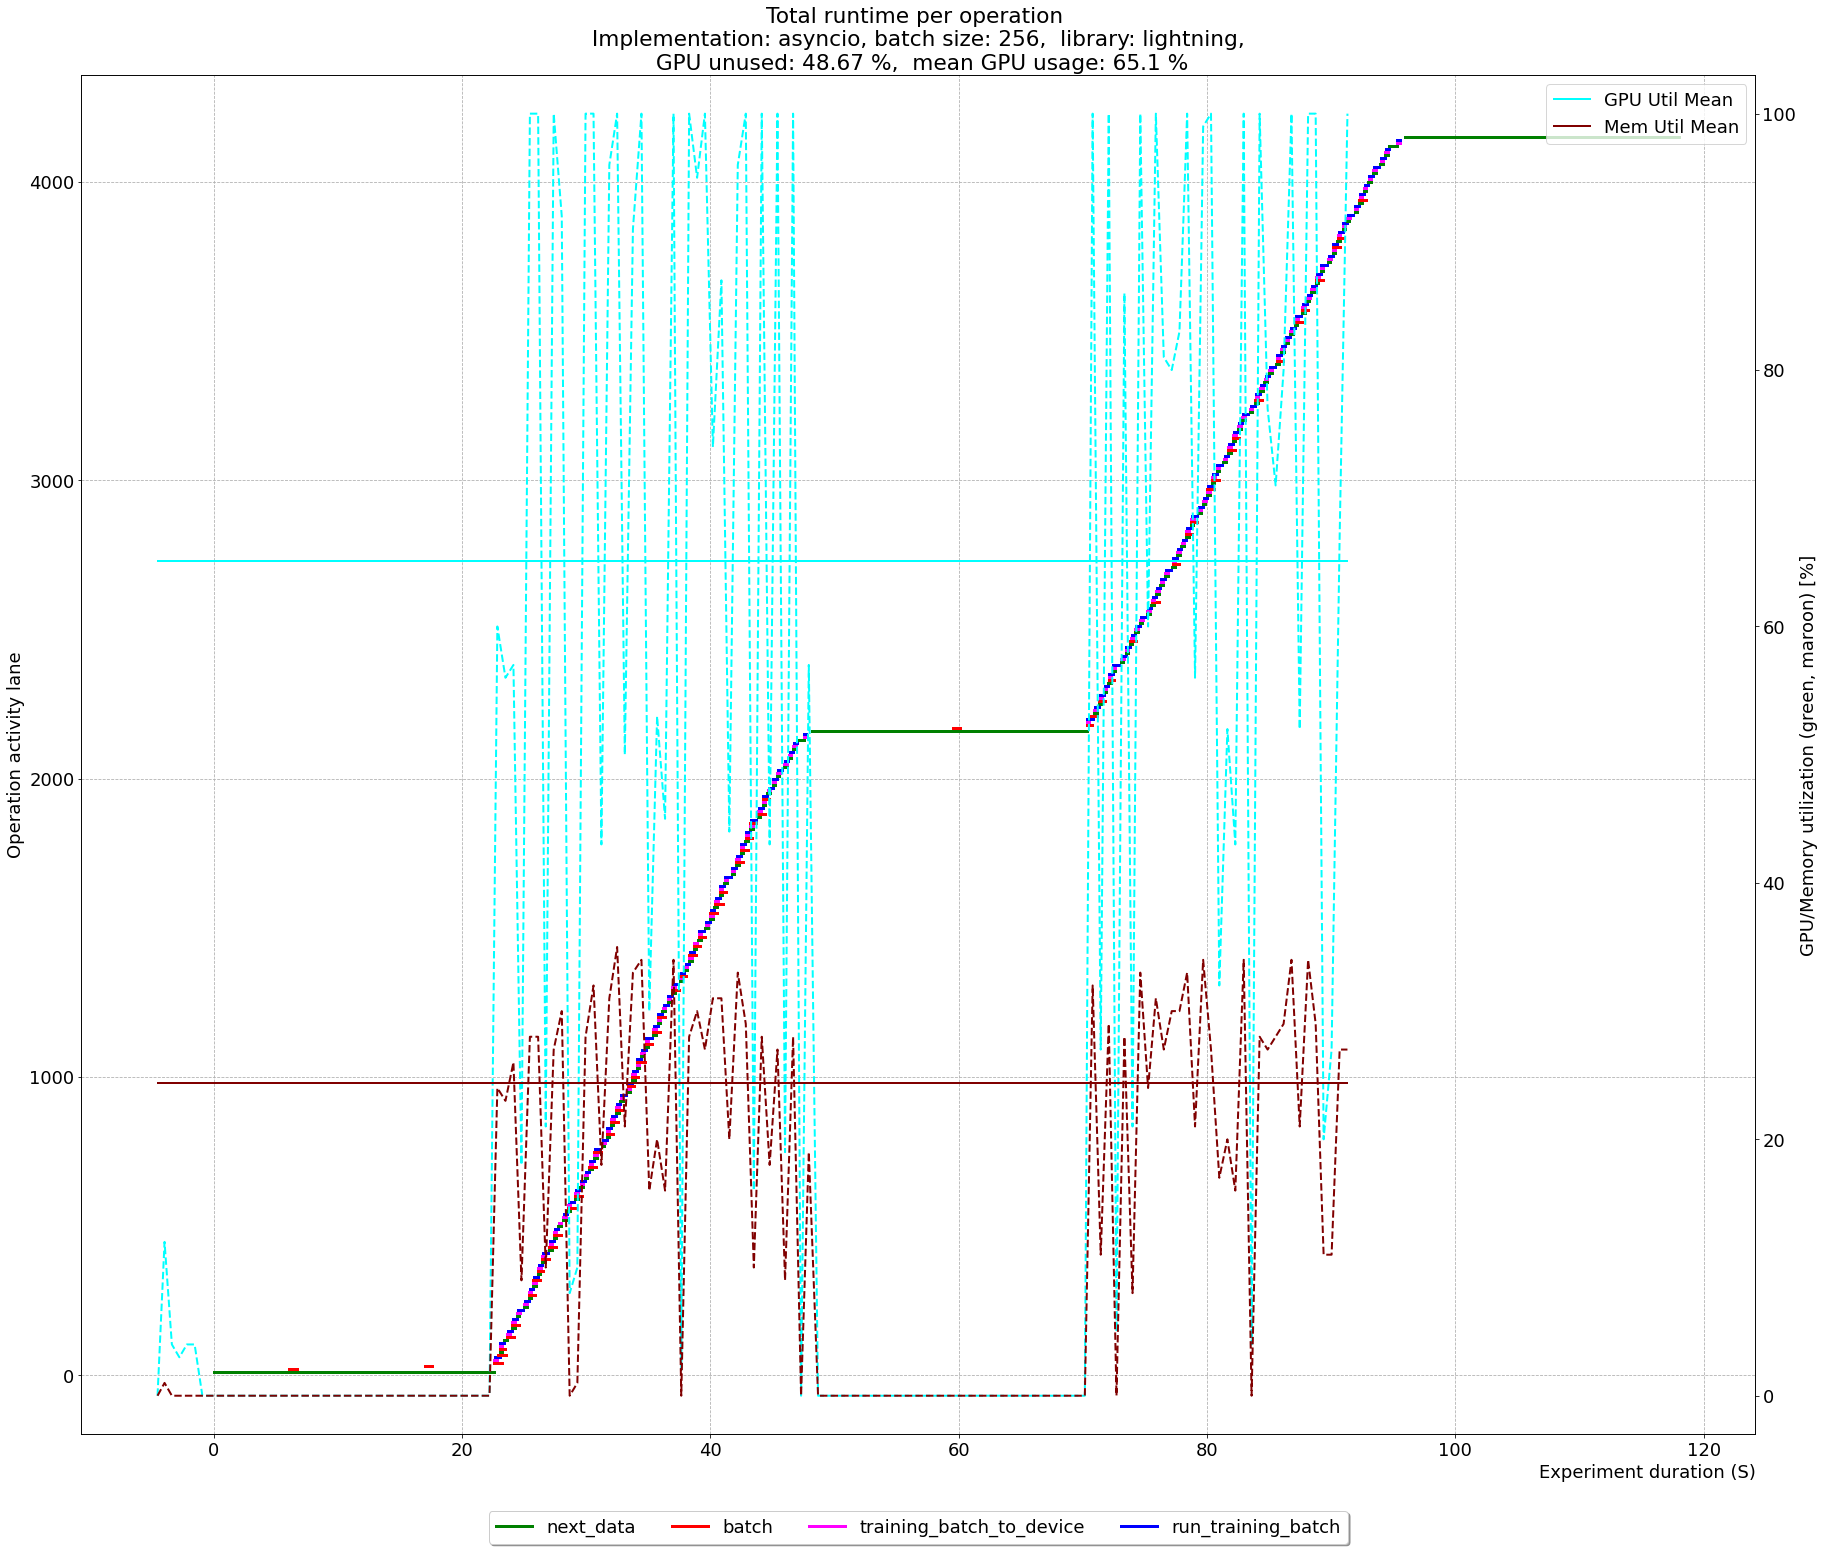

70.47540983606558 41.6271186440678


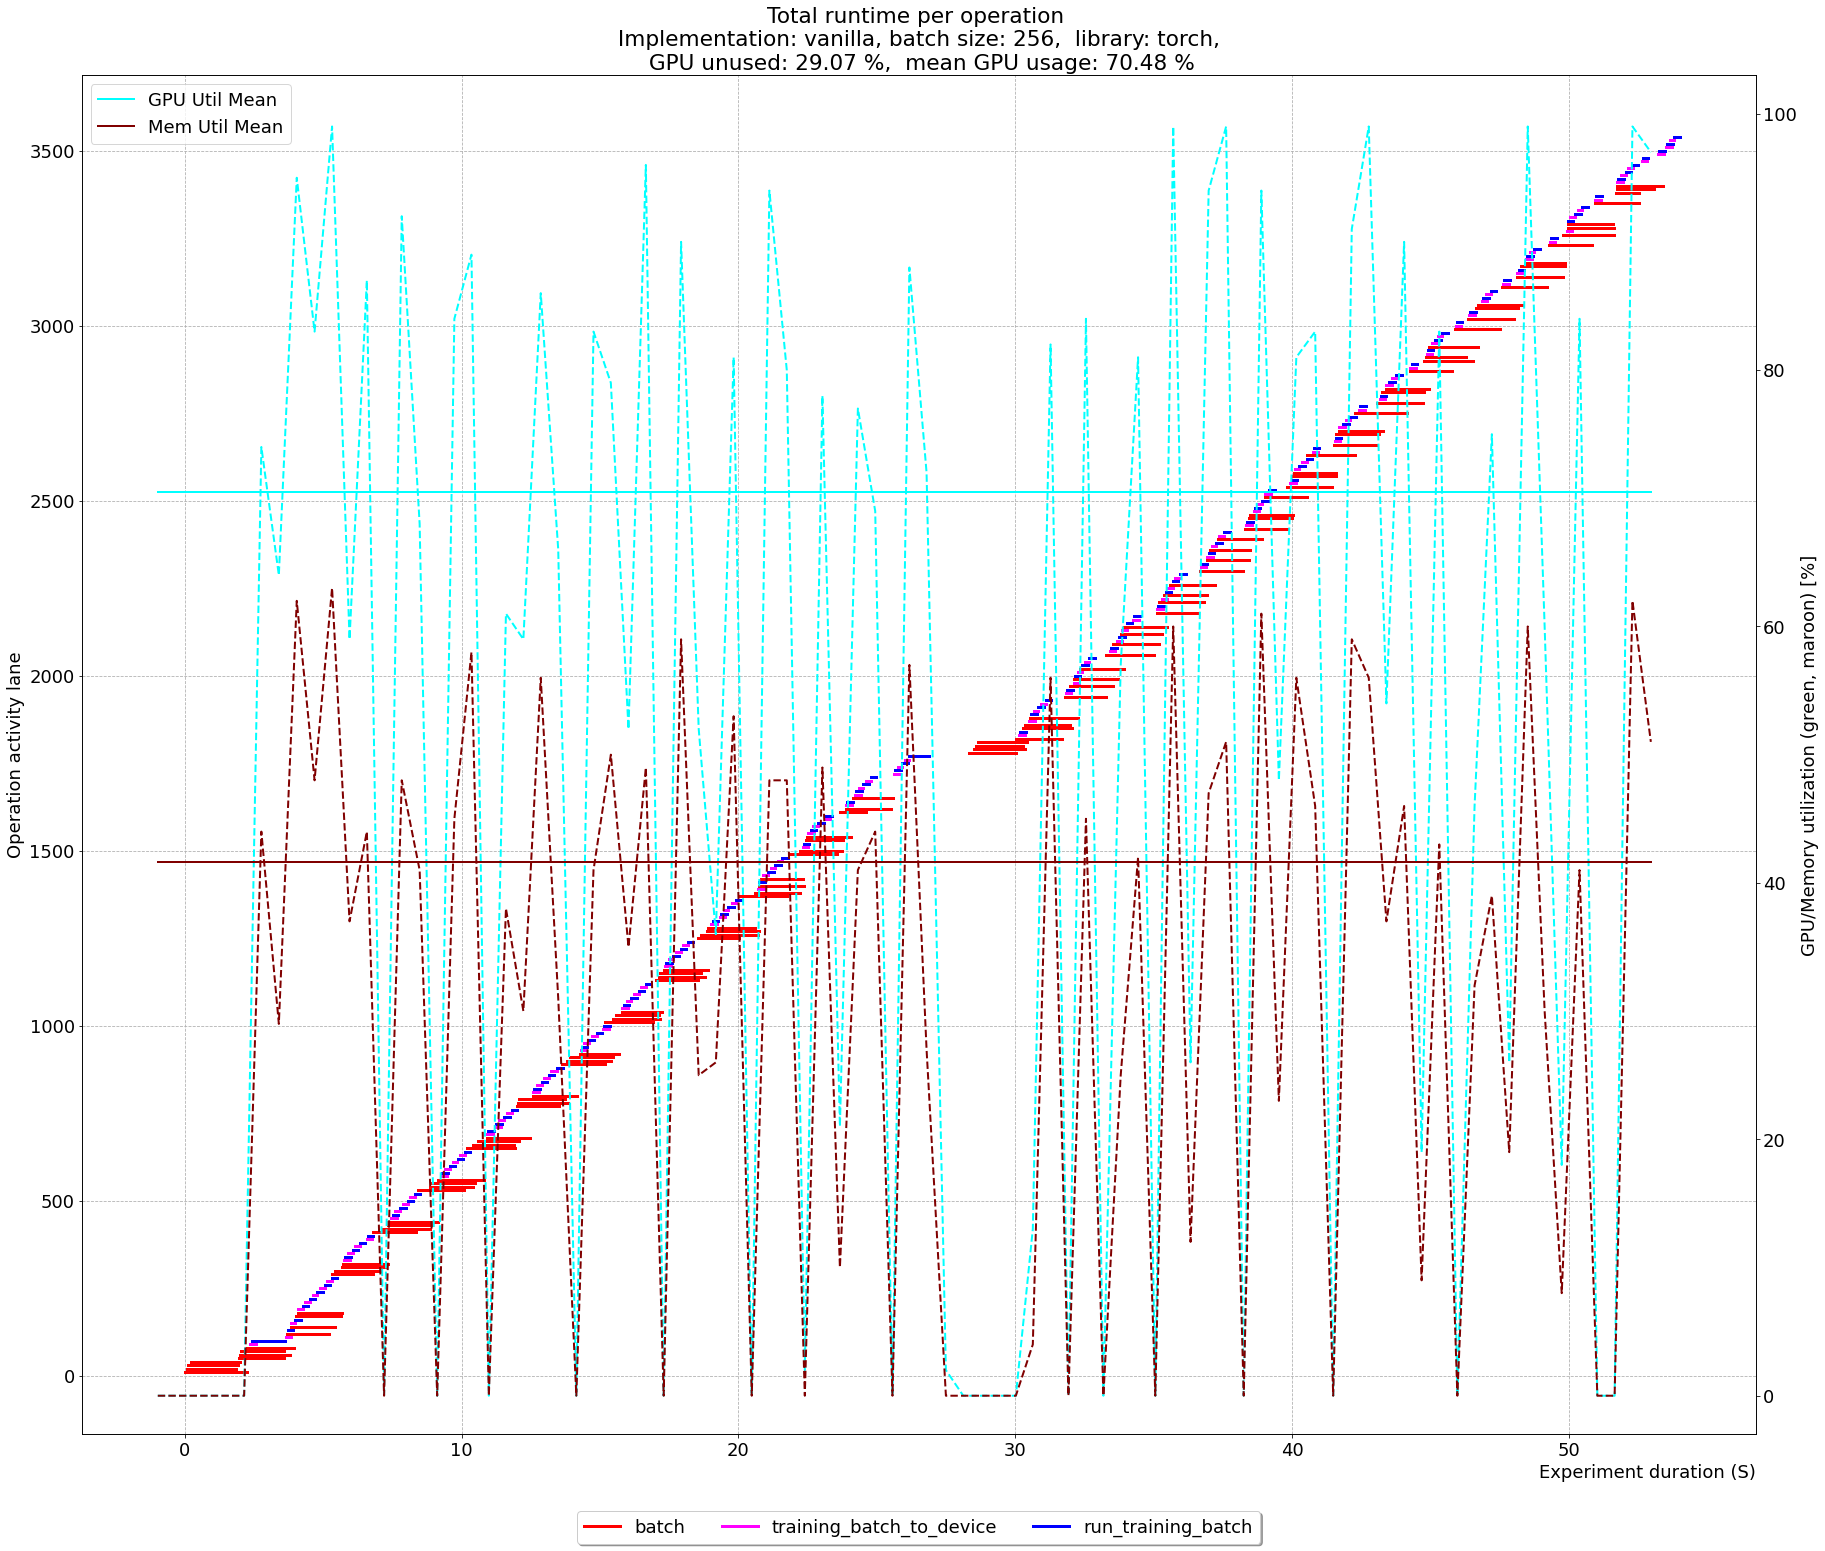

62.864583333333336 24.107142857142858


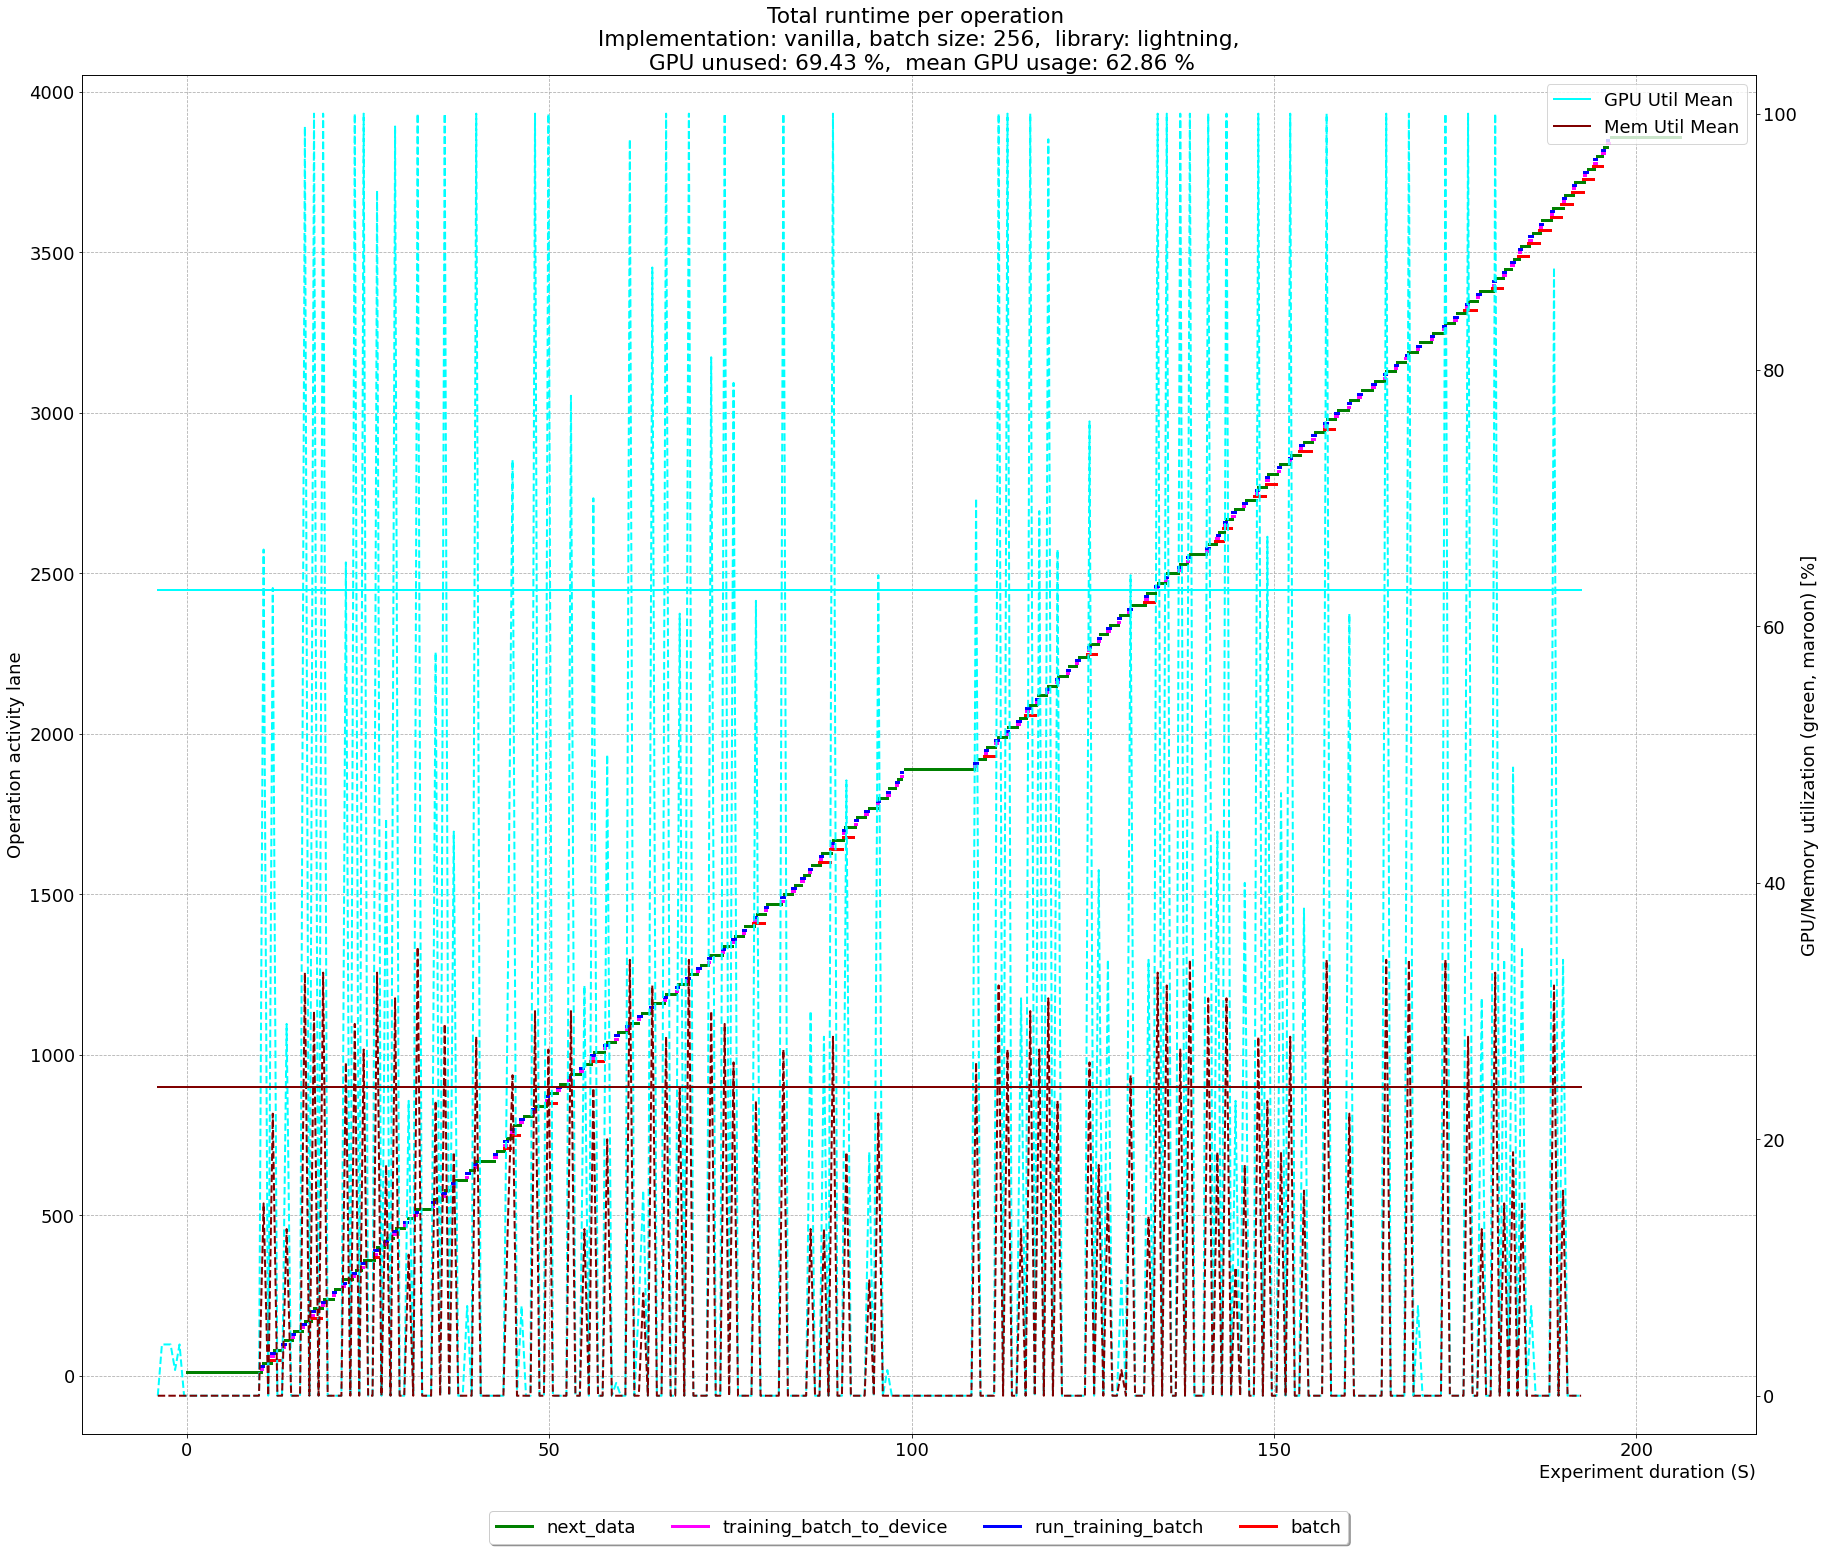

In [32]:
returns_scratch = []
for run in sorted(unique_runs_scratch):
    df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
    dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
    df = df.drop_duplicates(subset="id", keep="first", inplace=False)
    result = show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, True, 2)
    result["run"]=run
    returns_scratch.append(result)

### Result tables
Print throughput in loaded images per second, and function duration in seconds, for S3 and Scratch

In [57]:
results_s3 = pd.DataFrame.from_records(data=returns_s3)
samples = 15000
epochs = 10

results_s3["throughput"] = samples / (results_s3["runtime"] / epochs)
results_s3.sort_values(["runtime", "library"], ascending=True)

runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0   1010.304649      59.740260               64.741935      14.889610   
2   1046.412807      62.345679               57.885246      11.598765   
1   1413.958675      53.603604               57.883495       9.040541   
3   1473.905270      65.217391               60.812500       7.034783   
4   8289.907510      93.964859               59.987342       1.961803   
5  38463.348358      98.260437               64.057143       0.369119   

   mem_util_mean_no_zeros implementation cache    library  \
0               39.534483       threaded     1      torch   
2               35.452830        asyncio     1      torch   
1               23.068966       threaded     1  lightning   
3               23.794118        asyncio     1  lightning   
4               35.178082        vanilla     1      torch   
5               23.452632        vanilla     1  lightning   

                                                 run  throughput  
0  20211110f232825_benchmark_e2e_torch_s3_256_4_1...  148.470068  
2  20211111f000909_benchmark_e2e_torch_s3_256_4_1...  143.346869  
1  20211110f234524_benchmark_e2e_lightning_s3_256...  106.085137  
3  20211111f002644_benchmark_e2e_lightning_s3_256...  101.770448  
4  20211111f005129_benchmark_e2e_torch_s3_256_4_1...   18.094291  
5  20211111f031032_benchmark_e2e_lightning_s3_256...    3.899816

In [58]:
results_scratch = pd.DataFrame.from_records(data=returns_scratch)
results_scratch["throughput"] = samples / (results["runtime"] / epochs)
results_scratch.sort_values(["runtime", "library"], ascending=True)

runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0   365.878214      13.793103               78.120000      38.293103   
2   375.544932      13.793103               76.500000      36.793103   
4   540.467122      29.069767               70.475410      28.558140   
1   957.281915      48.666667               67.597403      11.600000   
3   964.449389      48.666667               65.103896      11.226667   
5  1968.215868      69.426752               62.864583       6.449045   

   mem_util_mean_no_zeros implementation cache    library  \
0               46.270833       threaded     1      torch   
2               42.680000        asyncio     1      torch   
4               41.627119        vanilla     1      torch   
1               25.588235       threaded     1  lightning   
3               24.405797        asyncio     1  lightning   
5               24.107143        vanilla     1  lightning   

                                                 run  throughput  
0  20211111f205911_benchmark_e2e_torch_scratch_25...  409.972484  
2  20211111f212315_benchmark_e2e_torch_scratch_25...  399.419582  
4  20211111f214714_benchmark_e2e_torch_scratch_25...  277.537696  
1  20211111f210705_benchmark_e2e_lightning_scratc...  156.693653  
3  20211111f213057_benchmark_e2e_lightning_scratc...  155.529156  
5  20211111f215633_benchmark_e2e_lightning_scratc...   76.211153

In [109]:
df_full = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)
subfolder = "1011_4"

# for run in sorted(unique_runs_s3):
for run in sorted(unique_runs_s3):
    with (output_base_folder / subfolder / run / "metadata.json").open() as f:
        metadata = json.load(f)
    
    epochs = metadata["epochs"] if "epochs" in metadata.keys() else metadata["max_epochs"]

    runtime = results_s3[results_s3["run"]==run]["runtime"].iloc(0)[0]
    total_images = len(df_full[(df_full["run"]==run) & (df_full["function_name"]=="__getitem__")]["len"]) 
    total_downloaded = df_full[(df_full["run"]==run) & (df_full["function_name"]=="__getitem__")]["len"].sum()
    downloaded_bitsps = total_downloaded / runtime

    print(f"Run: {run}", metadata["batch_size"], epochs)
    print(f"bits/s: {downloaded_bitsps}")
    print(f"bytes/s: {downloaded_bitsps / 8}")
    print(f"Kbytes/s: {downloaded_bitsps / (8 * 1000)}")
    print(f"Mbytes/s: {downloaded_bitsps / (8 * 1000 * 1000)}")
    print(f"Mbits/s: {downloaded_bitsps / (1e6)}")
    print(f"imgs/s: {total_images / runtime}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [00:28<00:00, 14.91it/s]


Run: 20211110f232825_benchmark_e2e_torch_s3_256_4_16_1_threaded_sync 256 20
bits/s: 53199392.72486005
bytes/s: 6649924.090607506
Kbytes/s: 6649.9240906075065
Mbytes/s: 6.649924090607506
Mbits/s: 53.19939272486005
imgs/s: 593.880272179106
Run: 20211110f234524_benchmark_e2e_lightning_s3_256_4_16_1_threaded_sync 256 20
bits/s: 19006069.532188952
bytes/s: 2375758.691523619
Kbytes/s: 2375.758691523619
Mbytes/s: 2.375758691523619
Mbits/s: 19.006069532188953
imgs/s: 212.17027429632338
Run: 20211111f000909_benchmark_e2e_torch_s3_256_4_16_1_asyncio_sync 256 20
bits/s: 67857017.74048877
bytes/s: 8482127.217561096
Kbytes/s: 8482.127217561096
Mbytes/s: 8.482127217561096
Mbits/s: 67.85701774048877
imgs/s: 573.3874774084301
Run: 20211111f002644_benchmark_e2e_lightning_s3_256_4_16_1_asyncio_sync 256 20
bits/s: 24087861.650081404
bytes/s: 3010982.7062601754
Kbytes/s: 3010.9827062601753
Mbytes/s: 3.0109827062601755
Mbits/s: 24.087861650081404
imgs/s: 203.54089654403302
Run: 20211111f005129_benchmark_e2

In [122]:
# df_full = extract_pandas(output_base_folder, folder_filter=scratch_folder_filter)
subfolder = "1111_5"
tps = []

for run in sorted(unique_runs_scratch):
    with (output_base_folder / subfolder / run / "metadata.json").open() as f:
        metadata = json.load(f)
    
    epochs = metadata["epochs"] if "epochs" in metadata.keys() else metadata["max_epochs"]
    dataset_size = metadata["dataset_limit"]

    runtime = results_scratch[results_scratch["run"]==run]["runtime"].iloc(0)[0]
    total_images = len(df_full[(df_full["run"]==run) & (df_full["function_name"]=="__getitem__")]["len"]) 
    total_downloaded = df_full[(df_full["run"]==run) & (df_full["function_name"]=="__getitem__")]["len"].sum()
    downloaded_bitss = total_downloaded / runtime

    print(f"Run: {run}", metadata["batch_size"], epochs)
    print(f"imgs/s: {total_images /  runtime}, { dataset_size / (runtime / epochs)}")
    print(f"bits/s: {downloaded_bitss}")
    print(f"Mbits/s: {downloaded_bitss / (1e6)}")
    print(f"Mbytes/s: {downloaded_bitss / (8 * 1000 * 1000)}")
    tps.append(downloaded_bitss / (1e6))

Run: 20211111f205911_benchmark_e2e_torch_scratch_256_4_16_1_threaded_sync 256 20
imgs/s: 1639.889935025635, 819.9449675128175
bits/s: 222595443.40958714
Mbits/s: 222.59544340958715
Mbytes/s: 27.824430426198393
Run: 20211111f210705_benchmark_e2e_lightning_scratch_256_4_16_1_threaded_sync 256 20
imgs/s: 313.3873056513027, 313.3873056513027
bits/s: 42538578.21213901
Mbits/s: 42.53857821213901
Mbytes/s: 5.317322276517376
Run: 20211111f212315_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync 256 20
imgs/s: 1597.678328984028, 798.839164492014
bits/s: 188900268.0802321
Mbits/s: 188.9002680802321
Mbytes/s: 23.612533510029014
Run: 20211111f213057_benchmark_e2e_lightning_scratch_256_4_16_1_asyncio_sync 256 20
imgs/s: 311.05831293924723, 311.05831293924723
bits/s: 36777740.32284314
Mbits/s: 36.777740322843144
Mbytes/s: 4.597217540355393
Run: 20211111f214714_benchmark_e2e_torch_scratch_256_4_16_1_vanilla_sync 256 20
imgs/s: 1110.150784803506, 555.0753924017529
bits/s: 131257823.96523875
Mbits/s:

In [124]:
results_scratch["tps"] = tps
results_scratch

runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
0   365.878214      13.793103               78.120000      38.293103   
1   957.281915      48.666667               67.597403      11.600000   
2   375.544932      13.793103               76.500000      36.793103   
3   964.449389      48.666667               65.103896      11.226667   
4   540.467122      29.069767               70.475410      28.558140   
5  1968.215868      69.426752               62.864583       6.449045   

   mem_util_mean_no_zeros implementation cache    library  \
0               46.270833       threaded     1      torch   
1               25.588235       threaded     1  lightning   
2               42.680000        asyncio     1      torch   
3               24.405797        asyncio     1  lightning   
4               41.627119        vanilla     1      torch   
5               24.107143        vanilla     1  lightning   

                                                 run  throughput         tps  
0  20211111f205911_benchmark_e2e_torch_scratch_25...  409.972484  222.595443  
1  20211111f210705_benchmark_e2e_lightning_scratc...  156.693653   42.538578  
2  20211111f212315_benchmark_e2e_torch_scratch_25...  399.419582  188.900268  
3  20211111f213057_benchmark_e2e_lightning_scratc...  155.529156   36.777740  
4  20211111f214714_benchmark_e2e_torch_scratch_25...  277.537696  131.257824  
5  20211111f215633_benchmark_e2e_lightning_scratc...   76.211153   18.021534

In [77]:
run = "20211110f234524_benchmark_e2e_lightning_s3_256_4_16_1_threaded_sync"
for run in unique_runs_s3:
#     print(np.unique(df_full["function_name"]))
    # pd.set_option('max_columns', None)
    total_downloaded = df_full[(df_full["run"]==run) & (df_full["function_name"]=="__getitem__")]["len"].sum()
    total_images = len(df_full[(df_full["run"]==run) & (df_full["function_name"]=="__getitem__")]["len"]) #.count()
    # df_full[(df_full["run"]==run) & (df_full["function_name"]=="advance")]
    print(run, total_downloaded, total_images)

20211110f232825_benchmark_e2e_torch_s3_256_4_16_1_threaded_sync 53747593800.0 600000
20211110f234524_benchmark_e2e_lightning_s3_256_4_16_1_threaded_sync 26873796900.0 300000
20211111f000909_benchmark_e2e_torch_s3_256_4_16_1_asyncio_sync 71006452440.0 600000
20211111f002644_benchmark_e2e_lightning_s3_256_4_16_1_asyncio_sync 35503226220.0 300000
20211111f005129_benchmark_e2e_torch_s3_256_4_16_1_vanilla_sync 71006452440.0 600000
20211111f031032_benchmark_e2e_lightning_s3_256_4_16_1_vanilla_sync 35503226220.0 300000


20211110f232825_benchmark_e2e_torch_s3_256_4_16_1_threaded_sync        53747593800.0 600000 -- ERROR
20211110f234524_benchmark_e2e_lightning_s3_256_4_16_1_threaded_sync    26873796900.0 300000 
20211111f000909_benchmark_e2e_torch_s3_256_4_16_1_asyncio_sync         71006452440.0 600000 -- ERROR
20211111f002644_benchmark_e2e_lightning_s3_256_4_16_1_asyncio_sync     35503226220.0 300000
20211111f005129_benchmark_e2e_torch_s3_256_4_16_1_vanilla_sync         71006452440.0 600000 -- ERROR!
20211111f031032_benchmark_e2e_lightning_s3_256_4_16_1_vanilla_sync     35503226220.0 300000

why is torch loading more data?!